# Ohio 2022 PBER

From Geoff: “What I would like by June 20th is a csv that assigns each 2020 Census block to a 2022 precinct from the Ohio SoS's general election results file.”

To Geoff: “…We've decided to start processing the shapefiles now so that there'll be minimal lag time between collection and release of the file. Although I don't anticipate this, in a worst case scenario, we'd be happy to share with you whatever intermediate file we have by June 20th.”

## Fine to use 2020 data vs Need digitization tracking

- * indicates adopted pre-2020 and therefore no updates needed
- P indicates the collection team only found PDF maps, no geospatial data

* ashtabula - used for 10 years except for single parcel change 1/24/23 in Orwell TWP/Orwell Vill
* P adams - not changed for 2022, not sure when first adopted
(P allen - map dated 9-28-21)
* athens - adopted in 2011
* P auglaize - date stamped 9/26/06
* belmont - adopted 2012/updated 2019
brown - adopted 5-21
butler - adopted 2-22
* P carrol - adopted 2019 or earlier
* P champaign - adopted 5-18
* P clinton - no change for 2022, not sure when first adopted
clark - adopted early 2022
clermont - adopted early 2022
columbiana - adopted 11-21
* P coshockton - no change for 2022, not sure when first adopted
* P crawford - no change for 2022, not sure when first adopted
cuyahoga - not sure when adopted
* P darke - no change for 2022, not sure when first adopted
* P defiance - first adopted 2018
delaware - adopted 2-2022
erie - adopted 1-2021
* fairfield - first adopted 2019
* fayette - adopted 2019 or earlier
* franklin - first adopted 8-2019
* fulton - first adopted 1-2019
* P gallia - no change for 2022, not sure when first adopted
geauga - first adopted 9-2021
* P greene - first adopted 2015, used 2020
* P guernsey - adopted 2005
hamilton - adopted early 2022
* hancock - adopted 2-2020, same map as 2020
hardin - no change for 2022, not sure when first adopted
* P harrison - wip, first adopted 2010
* henry - first adopted 1-2019
* highland - first adotped 2018 - cant be used but do match 2020 seems
hocking - first adopted 2021/2022
* holmes - first adopted 1/1/14
(P huron - first adoped 3/17 or 2021, based on map date stamp vs BOE director)
* P jackson - "many years ago"
* jefferson - adopted 2012
* knox - adopted 11/2019
* lawrence - precinct havent changed in 20 years, they claim
lake - first adopted 2021
* licking - first adopted 2015
* logan - "Used the 2018 map for all three 2022 elections"
* lorain - adopted after 2022 general election (so ...2022 general and prim used 2020 precs?)
* lucas - adopted 2019
(P madison - adopted 2022 (before or after elections?))
* mahoning - adopted 2012
* marion - adopted august 2015 used for primary elections, august 2022 map used for gen elec
medina - no info in metadata on previous use
* meigs - no change for 2022 - think this means same as 2020
mercer - new for 2022
miami - new for 2022
* monroe - adopted pre-2018
* P morgan - adopted pre-2019
* morrow - adopted 2017 or earlier
montgomery - adopted march 2022, used in primaries too
muskingum - adopted 2022
* noble - no 2022 changes, think this means same as 2020
* ottawa - adopted December 2022, so I think 2020 map likely used for actual elections?
* paulding - adopted pre 2020
* perry - adopted 2013
pickaway - adopted early 2022
* P pike - adopted 2002
portage - adopted 2022 for general, 2017 for primary
* P preble - no 2022 changes, so I think 2020 map works
* putnam - no 2022 changes, stamped 2019 - given other spots that say "before 2020" not sure
* richland - adopted 2018 or earlier
* ross - adopted 2013
* P sandusky - adopted 2009
* P scioto - adopted before 2020
* shelby - adopted before 2020
stark - adopted 2022
* summit - adopted 2013, a change in 2017 (and dec 2022?)
tuscarawas - adopted between 2020 and 2022
* union - adopted 2019
* P vanwert - adopted pre-2020
* P vinton - adopted pre-2020
* warren - adopted pre-2020
* washington - adopted 2016 or earlier
* wayne - adopted 2015, some updates since (not nec any one shp ever used??)
* williams - adopted pre-2019
wood - adopted early 2022
* P wyandot - adopted 2019 - one 2022 update due to cong split (?)

## Imports libraries and 2022 Election Results

In [1]:
import os
import numpy as np 
import geopandas as gp
import pandas as pd
from op_verification import reference_data
import time
import warnings
warnings.filterwarnings('ignore')


#set of counties with new precinct boundaries since 2020 and therefore new precinct name matching required
prec_counties_new22_set = {"brown","butler","clark","clermont","columbiana","cuyahoga","delaware", "erie","geauga","hamilton","hardin", 
                           "hocking","lake","lucas","lorain","marion","medina","mercer","miami","montgomery","muskingum","pickaway","portage",
                           "stark","tuscarawas","wood"}
#Remove "lorain", bc spencer said matches expected --- add back in because actually does need mod
#Removed from above set after checking pdf map with 2020 map by SN on 6/7: ,"madison", "huron"
#Removed because no 2022 available and statement that no changes since 2020: "allen"
print(len(prec_counties_new22_set))


#2022 precinct eletion results, no geospatial data
er22 = pd.read_csv('./raw-from-source/oh_2022_gen_prec/oh_2022_gen_prec.csv')

26


## Compare 2020 boundary precincts to 2022 election result precincts
Note "ZZZ"/"VOTING DISTRICTS NOT DEFINED" refers to water areas with no precinct but should be included in the map#Note "ZZZ"/"VOTING DISTRICTS NOT DEFINED" refers to water areas with no precinct but should be included in the map

In [2]:
#2020 precinct boundaries and election results file filtered for only boundaries
bound20rdh = gp.read_file("./raw-from-source/oh_gen_20_prec/oh_gen_20_st_prec.shp")[['UNIQUE_ID', "STATEFP20","COUNTYFP20", "PRECINCT20","NAME20","geometry"]]
#Format county/county name columns to maptch ER22 for comparison
bound20rdh['COUNTY'] = ("39"+bound20rdh['COUNTYFP20']).map(reference_data.geoid_to_county_name)
bound20rdh['COUNTYNM'] = bound20rdh['COUNTY'].str.lower().str.slice(stop=-7)
county_name_to_fips_dict = pd.Series(bound20rdh['COUNTYFP20'].values, index=bound20rdh['COUNTYNM']).to_dict()
#Confirm county names match up
assert set(bound20rdh['COUNTYNM'])-set(er22["County"].str.lower()) == set()
assert set(er22["County"].str.lower())-set(bound20rdh['COUNTYNM']) == set()
#Considering 2020/2022 comparison some more
print("2022 ER unique_id nunique: ",er22["UNIQUE_ID"].nunique() ,"\nshape: ", er22["UNIQUE_ID"].shape, "\nprec name nunique: ", er22["PRECNAME"].nunique(), "\nprec name w county nunique",(er22["PRECCODE"]+er22["County"]).nunique())
print("2020 PB NAME20 nunique: ",bound20rdh["NAME20"].nunique(),"\nshape:",bound20rdh.shape, "\nprec name nunique: ",bound20rdh["PRECINCT20"].nunique(),"\nprec name w county nunique",(bound20rdh["PRECINCT20"]+bound20rdh["COUNTYNM"]).nunique())
'''
Bounds have more unique, but also includes the ZZZ dist, which includes precincts with 0 voters, so should be ok/expected
Include zzz vtd shapes with note in readme that they were not assigned votes
'''


#set of counties with reused precinct boundaries from pre-2020, therefore can use 2020 geospatial data
counties_reused22_set = set(er22["County"].str.lower())-prec_counties_new22_set
#2022 ER df subset counties where geospatial data can be reused
er22_reused_counties_df = er22[er22["County"].str.lower().isin(counties_reused22_set)]
#2020 Bound gdf subset counties where geospatial data can be reused
bound20_reused_counties_gdf = bound20rdh[(bound20rdh["COUNTYNM"].isin(counties_reused22_set))|(bound20rdh["PRECINCT20"]=="ZZZ")]
#Check if Precincts line up/what mismatches - as expected, only for ZZZ 0 voter precicnts
print("\n prec w/county diff: pb comp er len: ", len(set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"].str.lower())-set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower())))
print("prec w/county diff: er comp pb len: ", len(set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower())-set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"])))
print("prec county diff: er comp pb names: ", set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower())-set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"]))
print("prec county diff: pb comp er names: ", set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"].str.lower())-set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower()))


#Create common column to join on
er22_reused_counties_df["UNIQUE_ID_code"] = er22_reused_counties_df["County"].str.upper() + "-"+er22_reused_counties_df["PRECCODE"]
bound20_reused_counties_gdf["UNIQUE_ID_code"] = bound20_reused_counties_gdf["COUNTYNM"].str.upper()+"-"+bound20_reused_counties_gdf["PRECINCT20"]
#Join 2020 bounds with 2022 ER where appropriate
pber_prec_reused_gdf = pd.merge(er22_reused_counties_df, bound20_reused_counties_gdf, on = "UNIQUE_ID_code", how = "outer", indicator=True)
print("shape merged gdf: ",pber_prec_reused_gdf.shape, "\nunmatched shape: ",pber_prec_reused_gdf[pber_prec_reused_gdf["_merge"]!="both"].shape)
print("county from er not matching: ",pber_prec_reused_gdf["County"][pber_prec_reused_gdf["_merge"]!="both"].unique())
print("county from bound not matching, not zzz: ",pber_prec_reused_gdf["COUNTYNM"][(pber_prec_reused_gdf["_merge"]!="both")&(pber_prec_reused_gdf["PRECINCT20"]!="ZZZ")].unique())

2022 ER unique_id nunique:  8933 
shape:  (8933,) 
prec name nunique:  8760 
prec name w county nunique 8933
2020 PB NAME20 nunique:  8673 
shape: (8941, 8) 
prec name nunique:  1550 
prec name w county nunique 8941

 prec w/county diff: pb comp er len:  8
prec w/county diff: er comp pb len:  0
prec county diff: er comp pb names:  set()
prec county diff: pb comp er names:  {'ZZZportage', 'ZZZlake', 'ZZZottawa', 'ZZZlorain', 'ZZZerie', 'ZZZlucas', 'ZZZashtabula', 'ZZZcuyahoga'}
shape merged gdf:  (4375, 269) 
unmatched shape:  (8, 269)
county from er not matching:  [nan]
county from bound not matching, not zzz:  []


## Precinct name matching 2022

**Full Match:** 
- precinct names match 2022 ER, precinct names are unique identifiers within the county

**Too many polygons:** 
- precinct names match 2022 ER, precinct names are unique within county in ER, NOT in PB - no identifier to differentiate in PB other than geometry col
    - Solution: dissolve by precinct name which matches with ER

**Questions addressed along the way:** 
- More polygons with unique precinct names in 2022 Precinct Boundary (PB) file than in 2022 Election Results (ER) File
    - Impacts: Butler, Cuyahoga
    - Solution: In cases where a precinct is split, merge together to match the ER (dissolve)
        - Example: In Butler County the Precinct Boundaries contain ( 'TRENTON1.MAD','TRENTON1.TRE') whereas the election results just contain 'TRENTON1'
        - In this case MAD and TRE in TRENTON1 would get merged together..
- Number of unique precinct names in boundary file does not match # polygons OR # unique precinct names in ER file
    - Impacts: Pickaway
    - Explanation: Boundary file has 77 rows, 35 unique precinct names, election results file has 43 unique precinct names
    - Solution: combine two separate shapefiles and use name matching spreadsheet provided by OE and BOE
- A few names with no match
    - Impacts: Erie 
    - Explanation: Erie (what to do with "Bellevue City-Annexed-Refer to Board of Elections" from boundary file? -- )
    - Solution: 
- No names match
    - Impacts: Wood
    - Explanation: After reading in all of the precinct shapes that the county provided separately, the precinct identifier is a number in the boundary file that does not match any of the identifiers in the election results
    - Solution: precinct name matching spreadsheet from OpenElections/BOE
    
- All names match, but null names in PB cause holes in plot
    - Impacts: Portage
    - Explanation: There are 129 precinct names in the ER. There are 129 names in PB that match ER. 
    - Solution: Merge with other part of precinct/name and dissolve for Ravenna, Arsenal, Tallmadge

In [3]:
len(prec_counties_new22_set)

26

In [5]:
def check_precid_uniqueness(county_gdf_list, ):
    '''
    Checks that the "prec_id" column created for each county gdf is unique within the county and that it matches the precinct identifiers in the election results df. 
    If it is not unique or does not match, function will return and assertion error
    Parameter county_df_list: list of dataframes where each dataframe is one county to be considered 
    '''
    print("number of counties in list: ",len(county_gdf_list))
    for county in county_gdf_list:
        print("check prec_id for: ", county["county"][0])
        assert county["prec_id"].nunique()==len(county)
        assert set(county["prec_id"])-set(er22["PRECNAME"][er22["County"].str.upper()==county["county"][0]])==set(er22["PRECNAME"][er22["County"].str.upper()==county["county"][0]])-set(county["prec_id"])==set()
    
    return "all counties pass check"

### Full Match

In [6]:
#Clark: Full match
clark = gp.read_file("./raw-from-source/boundaries/clark_precincts_2023/ClarkCountyPrecinctData.shp")
clark['prec_id'] = "PRECINCT "+clark['NAME']
clark.loc[clark['NAME'].str.contains("BETHEL"), "prec_id"] = clark['prec_id'].str.replace("BETHEL", "BETH")
clark.loc[clark['NAME'].str.contains(" 0"), "prec_id"] = clark['prec_id'].str.replace(" 0", " ")
clark.loc[clark['NAME'].str.contains("MR "), "prec_id"] = clark['prec_id'].str.replace("MR ", "MR-")
clark.loc[clark['NAME'].str.contains("HARMONY"), "prec_id"] = clark['prec_id'].str.replace("HARMONY", "HARM")
clark.loc[clark['NAME'].str.contains("T-0"), "prec_id"] = clark['prec_id'].str.replace("T-0", "T-")
clark.loc[clark['NAME'].str.contains("GERMAN"), "prec_id"] = clark['prec_id'].str.replace("GERMAN", "GERM")
clark.loc[clark['NAME'].str.contains("GREEN"), "prec_id"] = clark['prec_id'].str.replace("GREEN", "GREE")
clark['county'] = 'CLARK'
clark['UNIQUE_ID'] = clark['county']+"-"+clark["prec_id"]
clark = clark.to_crs(bound20_reused_counties_gdf.crs)


#Columbiana: Full match
columbiana = gp.read_file("./raw-from-source/boundaries/columbiana_precincts_2022/Voting_Precincts_2022.shp")
columbiana_dict = {"HANOVER TWP NW":'PRECINCT HANOVER TWP NORTH',"WELLSVILLE 2":'PRECINCT WELLSVILLE  2',"PERRY SW":'PRECINCT PERRY TWP SW',
                   "PERRY NORTH":'PRECINCT PERRY TWP NORTH',"LEETONIA":'PRECINCT LEETONIA VIL', "NEGLEY":'PRECINCT MIDDLETON TWP NEGLEY',
                   "ROGERS":'PRECINCT MIDDLETON TWP ROGERS',"ST CLAIR SOUTH":'PRECINCT ST CLAIR TWP SOUTH',
                   "WEST TWP E ROCHESTER":'PRECINCT WEST TWP EAST ROCHESTER',"WELLSVILLE 1":'PRECINCT WELLSVILLE  1'}
columbiana["prec_id"] = "PRECINCT "+columbiana["PRECNAME"].str.upper().str.replace("TOWNSHIP", "TWP")
columbiana.loc[columbiana["PRECNAME"].isin(columbiana_dict.keys()), "prec_id"] = columbiana["PRECNAME"].map(columbiana_dict)
columbiana["county"] = "COLUMBIANA"
columbiana["UNIQUE_ID"] = columbiana["county"]+"-"+columbiana["prec_id"]
columbiana = columbiana.to_crs(bound20_reused_counties_gdf.crs)


#Delaware: Full match
delaware = gp.read_file("./raw-from-source/boundaries/delaware_precincts_2022/Precinct.shp")
delaware['prec_id'] = "PRECINCT " + delaware['PREC_NAME'].str.upper()
delaware["county"] = "DELAWARE"
delaware.loc[delaware["PREC_NAME"].str.contains("COLUMBUS"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("COLUMBUS ", "COLUMBUS CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("DUBLIN"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("DUBLIN ", "DUBLIN CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("POWELL"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("POWELL ", "POWELL CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("SUNBURY"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("SUNBURY ", "SUNBURY CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("WESTERVILLE"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("WESTERVILLE ", "WESTERVILLE CITY ")
delaware["UNIQUE_ID"] = delaware["county"]+"-"+delaware["prec_id"]
delaware = delaware.to_crs(bound20_reused_counties_gdf.crs)


#Geauga: Full Match
geauga = gp.read_file("./raw-from-source/boundaries/geauga_precincts_2022/Precincts.shp")
geauga_prec_dict = {"B-76":"PRECINCT THOMPSON TWP B","B-51":"PRECINCT MONTVILLE TWP B", "C-42":"PRECINCT HAMBDEN TWP C", "A-23":"PRECINCT CHARDON TWP A","D-22":"PRECINCT CHARDON CITY D", "A-44":"PRECINCT HUNTSBURG TWP A", "B-38":"PRECINCT CLARIDON TWP B", "E-56":"PRECINCT MUNSON TWP E",
"D-30":"PRECINCT CHESTER TWP D","AQV-36":"PRECINCT AQUILLA VILLAGE", "B-49":"PRECINCT MIDDLEFIELD TWP B", "C-18":"PRECINCT BURTON TWP C", "A-58":"PRECINCT NEWBURY TWP A", "A-70":"PRECINCT RUSSELL TWP A", "HVV-69":"PRECINCT HUNTING VALLEY VILL", 
"B-47":"PRECINCT MIDDLEFIELD VILL B",
"BUR V-15":"PRECINCT BURTON VILLAGE", "B-64":"PRECINCT PARKMAN TWP B", "A-77":"PRECINCT TROY TWP A", "E-5":"PRECINCT AUBURN TWP E","F-11":"PRECINCT BAINBRIDGE TWP F", "A-75":"PRECINCT THOMPSON TWP A", "A-50":"PRECINCT MONTVILLE TWP A", "B-45":"PRECINCT HUNTSBURG TWP B", 
"A-46":"PRECINCT MIDDLEFIELD VILL A", "A-63":"PRECINCT PARKMAN TWP A", "B-78":"PRECINCT TROY TWP B", "A-16":"PRECINCT BURTON TWP A", "B-17":"PRECINCT BURTON TWP B", "A-37":"PRECINCT CLARIDON TWP A", "B-41":"PRECINCT HAMBDEN TWP B", "A-40":"PRECINCT HAMBDEN TWP A",
"D-43":"PRECINCT HAMBDEN TWP D", "C-25":"PRECINCT CHARDON TWP C","D-26":"PRECINCT CHARDON TWP D", "B-24":"PRECINCT CHARDON TWP B", "A-19":"PRECINCT CHARDON CITY A", "C-21":"PRECINCT CHARDON CITY C", "B-20":"PRECINCT CHARDON CITY B", "B-53":"PRECINCT MUNSON TWP B", 
"C-54":"PRECINCT MUNSON TWP C","F-57":"PRECINCT MUNSON TWP F", "B-59":"PRECINCT NEWBURY TWP B", "C-60":"PRECINCT NEWBURY TWP C", "E-62":"PRECINCT NEWBURY TWP E","D-61":"PRECINCT NEWBURY TWP D", "C-3":"PRECINCT AUBURN TWP C", "B-2":"PRECINCT AUBURN TWP B", 
"A-1":"PRECINCT AUBURN TWP A","D-4":"PRECINCT AUBURN TWP D", "A-6":"PRECINCT BAINBRIDGE TWP A", "C-8":"PRECINCT BAINBRIDGE TWP C", "E-10":"PRECINCT BAINBRIDGE TWP E","H-13":"PRECINCT BAINBRIDGE TWP H","I-14":"PRECINCT BAINBRIDGE TWP I","D-9":"PRECINCT BAINBRIDGE TWP D",
"D-68":"PRECINCT SOUTH RUSSELL VILL D", "B-66":"PRECINCT SOUTH RUSSELL VILL B", "A-65":"PRECINCT SOUTH RUSSELL VILL A", "C-67":"PRECINCT SOUTH RUSSELL VILL C", "E-74":"PRECINCT RUSSELL TWP E", "C-72":"PRECINCT RUSSELL TWP C", "B-71":"PRECINCT RUSSELL TWP B",
"D-73":"PRECINCT RUSSELL TWP D", "C-29":"PRECINCT CHESTER TWP C","G-33":"PRECINCT CHESTER TWP G","H-34":"PRECINCT CHESTER TWP H","I-35":"PRECINCT CHESTER TWP I", "A-27":"PRECINCT CHESTER TWP A", "B-28":"PRECINCT CHESTER TWP B", "E-31":"PRECINCT CHESTER TWP E",
"F-32":"PRECINCT CHESTER TWP F", "B-7":"PRECINCT BAINBRIDGE TWP B","G-12":"PRECINCT BAINBRIDGE TWP G","D-55":"PRECINCT MUNSON TWP D", "A-52":"PRECINCT MUNSON TWP A", "C-39":"PRECINCT CLARIDON TWP C", "A-48":"PRECINCT MIDDLEFIELD TWP A"}
geauga["prec_id"] = "na"
geauga.loc[geauga['PRECINCT2'].isin(geauga_prec_dict.keys()), "prec_id"] = geauga["PRECINCT2"].map(geauga_prec_dict)
geauga["county"] = "GEAUGA"
geauga["UNIQUE_ID"] = geauga["county"]+"-"+geauga["prec_id"]
geauga = geauga.to_crs(bound20_reused_counties_gdf.crs)


#Hamilton: Full Match
hamilton = gp.read_file("./raw-from-source/boundaries/hamilton_precincts_2022/PRECINT2021_0311.shp")
hamilton['prec_id'] = hamilton["PRC_NAME"]
hamilton['county'] = "HAMILTON"
hamilton["UNIQUE_ID"] = hamilton["county"]+"-"+hamilton["prec_id"]
hamilton = hamilton.to_crs(bound20_reused_counties_gdf.crs)


#Hardin: Full Match
hardin = gp.read_file("./raw-from-source/boundaries/hardin_precincts_2022/Hardin_Co_Precincts_2023-04.shp")
hardin["prec_id"] = hardin["precinct"].str.upper()
hardin["county"] = "HARDIN"
hardin["UNIQUE_ID"] = hardin["county"]+"-"+hardin["prec_id"]
hardin = hardin.to_crs(bound20_reused_counties_gdf.crs)


#Hocking: Full Match
hocking = gp.read_file("./raw-from-source/boundaries/hocking_precincts_2022/HOCKING_COUNTY_PRECINCTS_2022.shp")
hocking["prec_id"] = "PRECINCT " + hocking["PRECINCT"]
hocking.loc[hocking["PRECINCT"]=="SALT CREEK", "prec_id"] = "PRECINCT SALTCREEK"
hocking["county"] = "HOCKING"
hocking["UNIQUE_ID"] = hocking["county"]+"-"+hocking["prec_id"]
hocking = hocking.to_crs(bound20_reused_counties_gdf.crs)


#Lake: Full Match
lake = gp.read_file("./raw-from-source/boundaries/lake_precincts_2021/Lake_County_Voting_Precincts_(2021).shp")
lake["prec_id"] = lake["NAME"].str.upper()
lake.loc[~lake["NAME"].str.upper().str.contains("MENTOR-ON"), "prec_id"] = "PRECINCT "+lake["NAME"].str.upper()
lake.loc[lake["NAME"].str.upper().str.contains("MENTOR-ON"), "prec_id"] = lake["NAME"].str.upper().str.slice(stop=-2)+"CITY "+lake["NAME"].str.upper().str.slice(start=-2)
lake["county"] = "LAKE"
lake["UNIQUE_ID"] = lake["county"]+"-"+lake["prec_id"]
lake = lake.to_crs(bound20_reused_counties_gdf.crs)


#Marion: Full Match
marion_aug=gp.read_file("./raw-from-source/boundaries/marion_precincts_2022/MARION_COUNTY_PRECINCTS_CONSOLIDATED_AUG2022.shp")
marion_dec = gp.read_file("./raw-from-source/boundaries/marion_precincts_2022/City_Council_Wards_December2022.shp")
marion_dec["PRCT_NAME"] = "MARION " + marion_dec["WARD_ID"].astype(str)+"-"+marion_dec["Prect"]
marion = gp.GeoDataFrame(pd.concat([marion_aug, marion_dec], ignore_index=True), crs=bound20_reused_counties_gdf.crs)
marion["prec_id"] = "PRECINCT "+marion["PRCT_NAME"]
marion_dict = {'PRECINCT BIG ISLAND':'PRECINCT BIG ISLAND TWP','PRECINCT BOWLING GREEN':'PRECINCT BOWLING GREEN TWP',
               'PRECINCT CLARIDON A':'PRECINCT CLARIDON TWP A','PRECINCT CLARIDON B':'PRECINCT CLARIDON TWP B',
               'PRECINCT GRAND PRAIRIE':'PRECINCT GRAND PRAIRIE TWP','PRECINCT GRAND-SALT':'PRECINCT GRAND SALT',
               'PRECINCT GREEN CAMP':'PRECINCT GREEN CAMP TWP','PRECINCT MARION A':'PRECINCT MARION TWP A','PRECINCT MARION B':'PRECINCT MARION TWP B',
               'PRECINCT MARION C':'PRECINCT MARION TWP C','PRECINCT MARION D':'PRECINCT MARION TWP D','PRECINCT MARION E':'PRECINCT MARION TWP E',
               'PRECINCT MARION F':'PRECINCT MARION TWP F','PRECINCT MONTGOMERY':'PRECINCT MONTGOMERY TWP','PRECINCT PLEASANT A':'PRECINCT PLEASANT TWP A',
               'PRECINCT PLEASANT B':'PRECINCT PLEASANT TWP B','PRECINCT PLEASANT C':'PRECINCT PLEASANT TWP C','PRECINCT PLEASANT D':'PRECINCT PLEASANT TWP D',
               'PRECINCT PROSPECT':'PRECINCT PROSPECT TWP','PRECINCT RICHLAND A':'PRECINCT RICHLAND TWP A','PRECINCT RICHLAND B':'PRECINCT RICHLAND TWP B',
               'PRECINCT SCOTT-TULLY':'PRECINCT SCOTT TULLY','PRECINCT WALDO':'PRECINCT WALDO TWP'}
marion.loc[marion["prec_id"].isin(marion_dict), "prec_id"] = marion["prec_id"].map(marion_dict)
marion["county"] = "MARION"
marion["UNIQUE_ID"] = marion["county"]+"-"+marion["prec_id"]
marion = marion.to_crs(bound20_reused_counties_gdf.crs)


#Mercer: Full Match
mercer = gp.read_file("./raw-from-source/boundaries/mercer_precincts_2023/2023_03_votingprecincts.shp")
mercer["prec_id"] = mercer["NAME"]
mercer["county"] = "MERCER"
mercer["UNIQUE_ID"] = mercer["county"]+"-"+mercer["prec_id"]
mercer = mercer.to_crs(bound20_reused_counties_gdf.crs)


#Muskingum: Full match
muskingum = gp.read_file("./raw-from-source/boundaries/muskingum_precincts_2022/VOTING_PRECINCTS.shp")
muskingum_dict = {'1A': 'PRECINCT ZANESVILLE 1-A', '1B': 'PRECINCT ZANESVILLE 1-B', '2A': 'PRECINCT ZANESVILLE 2-A', '2B': 'PRECINCT ZANESVILLE 2-B', '3A': 'PRECINCT ZANESVILLE 3-A', '3B': 'PRECINCT ZANESVILLE 3-B', 
                  '4A': 'PRECINCT ZANESVILLE 4-A', '4B': 'PRECINCT ZANESVILLE 4-B', '5A': 'PRECINCT ZANESVILLE 5-A', '5B': 'PRECINCT ZANESVILLE 5-B', '5C': 'PRECINCT ZANESVILLE 5-C', '6A': 'PRECINCT ZANESVILLE 6-A', 
                  '6B': 'PRECINCT ZANESVILLE 6-B', '6C': 'PRECINCT ZANESVILLE 6-C', 'NEWTON FULTONHAM': 'PRECINCT FULTONHAM', 'NEWTON IRONSPT': 'PRECINCT IRONSPOT', 'NEWTON MOXAHALA': 'PRECINCT MOXAHALA', 
                  'NEWTON ROLLING PLAINS': 'PRECINCT ROLLING PLAINS', 'NEWTON WHITE COTTAGE': 'PRECINCT WHITE COTTAGE', 'UNION UNION': 'PRECINCT UNION', 'WAYNE DUNCAN FALLS':'PRECINCT DUNCAN FALLS'}
muskingum["prec_id"] = "PRECINCT "+muskingum["PRECINCT"]
muskingum.loc[muskingum["PRECINCT"].isin(muskingum_dict.keys()), "prec_id"] = muskingum["PRECINCT"].map(muskingum_dict)
muskingum["county"] = "MUSKINGUM"
muskingum["UNIQUE_ID"] = muskingum["county"]+"-"+muskingum["prec_id"]
muskingum = muskingum.to_crs(bound20_reused_counties_gdf.crs)


#Tuscarawas: Full match
tuscarawas = gp.read_file("./raw-from-source/boundaries/tuscarawas_precincts_2020_2022/BOE_Precincts_2022/Tusc157_BOE_PctBnd.shp")
tuscarawas_dict_df = pd.read_csv("./raw-from-source/boundaries/tuscarawas_precincts_2020_2022/BOE_Precincts_2022/prec_matching.csv")
tuscarawas_dict = pd.Series(tuscarawas_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index = tuscarawas_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1)).to_dict()
tuscarawas["prec_id"] = "PRECINCT "+tuscarawas["PRECT_NA"]
tuscarawas.loc[tuscarawas["prec_id"].isin(tuscarawas_dict.keys()), "prec_id"] = tuscarawas["prec_id"].map(tuscarawas_dict)
tuscarawas["county"] = "TUSCARAWAS"
tuscarawas["UNIQUE_ID"] = tuscarawas["county"]+"-"+tuscarawas["prec_id"]
tuscarawas = tuscarawas.to_crs(bound20_reused_counties_gdf.crs)


#Check if uniqueness/match fixed
full_match_22_bound=[clark, columbiana, delaware, geauga, hamilton, hardin, hocking, lake, marion,mercer, muskingum, tuscarawas]
check_precid_uniqueness(full_match_22_bound) 

number of counties in list:  12
check prec_id for:  CLARK
check prec_id for:  COLUMBIANA
check prec_id for:  DELAWARE
check prec_id for:  GEAUGA
check prec_id for:  HAMILTON
check prec_id for:  HARDIN
check prec_id for:  HOCKING
check prec_id for:  LAKE
check prec_id for:  MARION
check prec_id for:  MERCER
check prec_id for:  MUSKINGUM
check prec_id for:  TUSCARAWAS


'all counties pass check'

### Full match, more geometries than ER precincts
Dissolve by precinct name to combine polygons with same name

In [7]:
#Brown: Full match 
brown = gp.read_file("./raw-from-source/boundaries/brown_precincts_2023/VOTING-PRECINCT.shp") #do the overlap labels have overlapping shapes also?
brown['prec_id'] = brown['NAME']
brown["county"] = "BROWN"
brown.loc[brown['NAME']=="ABERDEEN", "prec_id"] = "ABERDEEN VILLAGE"
brown.loc[brown['NAME']=="LEWIS HIGGINSPORT", "prec_id"] = "LEWIS/HIGGINSPORT"
brown.loc[brown['NAME']=="MT ORAB STERLING", "prec_id"] = "MOUNT ORAB VILLAGE WEST"
brown.loc[brown['NAME']=="PERRY LAKE LORELEI", "prec_id"] = "PERRY / LAKE LORELEI"
brown.loc[brown['NAME']=="PERRY TWP VILLAGES", "prec_id"] = "PERRY TWP-VILLAGES"
brown.loc[brown['NAME']=="SARDINIA", "prec_id"] = "SARDINIA VILLAGE"
brown["UNIQUE_ID"] = brown["county"] + "-" + brown['prec_id']
brown = brown.dissolve(by = "UNIQUE_ID").reset_index()
brown = brown.to_crs(bound20_reused_counties_gdf.crs)


#Butler: Full match, combine prec
butler = gp.read_file("./raw-from-source/boundaries/butler_precincts_2023/2023Precincts.shp")
butler_dict_df = pd.read_csv("./raw-from-source/boundaries/butler_precincts_2023/prec_name_matching.csv")
butler['prec_id'] = butler['NEW_PREC_N'].str.upper().str.replace("FFTWP", "FAIRFIELD TWP ").str.replace("HANOVER", "HANOVER TWP ").str.replace(
    "LEMON", "LEMON TWP ").str.replace("LIBERTY", "LIBERTY TWP ").str.replace("WC", "WEST CHESTER TWP ")
butler_dict = pd.Series(butler_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index = butler_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1).values).to_dict()
butler.loc[butler["prec_id"].isin(butler_dict.keys()), "prec_id"] = butler["prec_id"].map(butler_dict)
#Dissolve
butler = butler.dissolve(by="prec_id").reset_index()
butler["county"] = "BUTLER"
butler["UNIQUE_ID"] = butler["county"]+"-"+butler["prec_id"]
butler = butler.to_crs(bound20_reused_counties_gdf.crs)


#Clermont: Full match
clermont = gp.read_file("boundaries/clermont_precincts_2023/VotingPrecincts.shp")
clermont['prec_id'] = clermont["PRECINCT"].str.upper().str.replace("TWP","TOWNSHIP")
clermont['county'] = "CLERMONT"
clermont["UNIQUE_ID"] = clermont['county']+"-"+clermont["prec_id"]
clermont = clermont.dissolve(by="UNIQUE_ID").reset_index()
clermont = clermont.to_crs(bound20_reused_counties_gdf.crs)


#Cuyahoga: Full match, combine prec
cuyahoga = gp.read_file("./raw-from-source/boundaries/cuyahoga_precincts_2022/Precincts May 2022_region.shp")
cuyahoga_dict_df = pd.read_csv("./raw-from-source/boundaries/cuyahoga_precincts_2022/prec_matching.csv")
cuyahoga_dict = pd.Series(cuyahoga_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index=cuyahoga_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1)).to_dict()
cuyahoga['prec_id'] = cuyahoga["City"].str.upper()+"-"+cuyahoga['Label'].str.slice(stop=-1).str.zfill(2)+"-"+cuyahoga['Label'].str.slice(start=-1)
cuyahoga.loc[cuyahoga["prec_id"].isin(cuyahoga_dict.keys()), "prec_id"] = cuyahoga["prec_id"].map(cuyahoga_dict)
cuyahoga.loc[cuyahoga["prec_id"]=='EACHWOOD-00-E', "prec_id"] = 'BEACHWOOD-00-E'
#Buffer small area, otherwise dissolve fails
cuyahoga["geometry"] = cuyahoga["geometry"].buffer(0.01)
cuyahoga = cuyahoga.dissolve(by="prec_id").reset_index()
cuyahoga['county'] = "CUYAHOGA"
cuyahoga["UNIQUE_ID"] = cuyahoga["county"]+"-"+cuyahoga["prec_id"]
cuyahoga = cuyahoga.to_crs(bound20_reused_counties_gdf.crs)
#print("# prec in PB not in ER: ",len(set(cuyahoga["prec_id"])-set(er22["PRECNAME"][er22["County"]=='Cuyahoga'])))
#print("# prec in ER not in PB: ",len(set(er22["PRECNAME"][er22["County"]=='Cuyahoga'])-set(cuyahoga["prec_id"])))
#print("nunique pb: ", cuyahoga["prec_id"].nunique(),"\nshape PB: ", cuyahoga.shape)
#print("nunique er: ",er22["PRECNAME"][er22["County"]=='Cuyahoga'].nunique())


#Erie: Full match except  {'Bellevue City-Annexed-Refer to Board of Elections'}
erie = gp.read_file("./raw-from-source/boundaries/erie_precincts_2022/Erie_County_Voting_Precincts.shp")
erie["prec_id"] = erie["Precinct_I"]
erie_prec_dict = {'Berlin Twp 1': 'PRECINCT BER TWP #1','Berlin Twp 2': 'PRECINCT BER TWP #2','Berlin Heights Village': 'PRECINCT BER VILL',
                  'Bay View Village': 'PRECINCT BV VILL','Castalia Village': 'PRECINCT CAST VILL','Florence Twp 1': 'PRECINCT FLO TWP #1',
                  'Florence Twp 2': 'PRECINCT FLO TWP #2','Groton Twp': 'PRECINCT GRO TWP','HUR-A': 'PRECINCT HUR A','HUR-B': 'PRECINCT HUR B',
                  'HUR-C': 'PRECINCT HUR C','HUR-D': 'PRECINCT HUR D','HUR-E': 'PRECINCT HUR E','HUR-F': 'PRECINCT HUR F','Huron Twp 1': 'PRECINCT HUR TWP #1',
                  'Huron Twp 2': 'PRECINCT HUR TWP #2','Huron Twp 3': 'PRECINCT HUR TWP #3','Kelleys Island Village': 'PRECINCT KI VILL',
                  'Margaretta Twp 1': 'PRECINCT MAR TWP #1','Margaretta Twp 2': 'PRECINCT MAR TWP #2','Margaretta Twp 3': 'PRECINCT MAR TWP #3',
                  'Margaretta Twp 4': 'PRECINCT MAR TWP #4','Milan Twp 1': 'PRECINCT MIL TWP #1','Milan Twp 2': 'PRECINCT MIL TWP #2',
                  'Milan Village': 'PRECINCT MIL VILL','Oxford Twp': 'PRECINCT OX TWP','Perkins Twp 1': 'PRECINCT PER TWP #1',
                  'Perkins Twp 10': 'PRECINCT PER TWP #10','Perkins Twp 2': 'PRECINCT PER TWP #2','Perkins Twp 3': 'PRECINCT PER TWP #3',
                  'Perkins Twp 4': 'PRECINCT PER TWP #4','Perkins Twp 5': 'PRECINCT PER TWP #5','Perkins Twp 6': 'PRECINCT PER TWP #6',
                  'Perkins Twp 7': 'PRECINCT PER TWP #7','Perkins Twp 8': 'PRECINCT PER TWP #8','Perkins Twp 9': 'PRECINCT PER TWP #9',
                  'SAN-A': 'PRECINCT SAN A','SAN-B': 'PRECINCT SAN B','SAN-C': 'PRECINCT SAN C','SAN-D': 'PRECINCT SAN D','SAN-E': 'PRECINCT SAN E',
                  'SAN-F': 'PRECINCT SAN F','SAN-G': 'PRECINCT SAN G','SAN-H': 'PRECINCT SAN H','SAN-I': 'PRECINCT SAN I','SAN-J': 'PRECINCT SAN J',
                  'SAN-K': 'PRECINCT SAN K','SAN-L': 'PRECINCT SAN L','SAN-M': 'PRECINCT SAN M','SAN-N': 'PRECINCT SAN N','SAN-O': 'PRECINCT SAN O',
                  'SAN-P': 'PRECINCT SAN P','Vermilion 1-A': 'PRECINCT VER 1-A','Vermilion 2-A': 'PRECINCT VER 2-A','Vermilion 2-B': 'PRECINCT VER 2-B',
                  'Vermilion 3-A': 'PRECINCT VER 3-A','Vermilion 3-B': 'PRECINCT VER 3-B','Vermilion Twp 1': 'PRECINCT VER TWP #1',
                  'Vermilion Twp 2': 'PRECINCT VER TWP #2','Vermilion Twp 3': 'PRECINCT VER TWP #3','Vermilion Twp 4': 'PRECINCT VER TWP #4',
                  'Vermilion Twp 5': 'PRECINCT VER TWP #5'}
erie.loc[erie['Precinct_I'].isin(erie_prec_dict.keys()), "prec_id"] = erie["Precinct_I"].map(erie_prec_dict)
#print("Not sure why the plot with everything is missing the shape in the bottom left present when plot without Groton...")
#erie[erie["Precinct_I"].str.contains("Groton")].plot()
#erie[~erie["Precinct_I"].str.contains("Groton")].plot()
#erie.plot()
#erie[erie["Precinct_I"].str.contains("Bellevue")].plot()
#erie[~erie["Precinct_I"].str.contains("Bellevue")].plot()
#Dissolve by prec id so Bellevue goes with Groton
erie.loc[erie["Precinct_I"]=="Bellevue City-Annexed-Refer to Board of Elections","prec_id"] = "PRECINCT GRO TWP"
erie = erie.dissolve(by="prec_id").reset_index()
#Standard
erie["county"] = "ERIE"
erie["UNIQUE_ID"] = erie["county"]+"-"+erie["prec_id"]
erie = erie.to_crs(bound20_reused_counties_gdf.crs)


#Lucas: Full match
lucas = gp.read_file("./raw-from-source/boundaries/lucas_precincts_2022/full_lucas_fixed/full_lucas_fixed.shp")
lucas_dict_df = pd.read_csv("./raw-from-source/boundaries/lucas_precincts_2022/Lucas_precinctMatching.csv")
lucas_dict_df.loc[~lucas_dict_df["mismatch comment"].isna(), "shapefile W___P"] = lucas_dict_df["mismatch W___P"]
lucas_dict = pd.Series(lucas_dict_df["SoS precinct Name"].values, index=lucas_dict_df["shapefile W___P"]).to_dict()
lucas["prec_id"] = lucas["W___P"].map(lucas_dict)
lucas.loc[lucas["W___P"]=="Mo10", "prec_id"] = "PRECINCT MONCLOVA 10"
lucas["county"] = "LUCAS"
lucas = lucas.dissolve(by="prec_id").reset_index()
lucas["UNIQUE_ID"] = lucas["county"]+"-"+lucas["prec_id"]
lucas = lucas.to_crs(bound20_reused_counties_gdf.crs)


#Miami: Full match except precinct names are not unique - 87 prec names but 104 geometries...
miami = gp.read_file("./raw-from-source/boundaries/miami_precincts_2022/All_Precincts.shp")
miami["prec_id"] = "PRECINCT "+miami["PrecName"].str.upper()
#DISSOLVE BY PREC
miami = miami.dissolve(by = "prec_id").reset_index()
#MATCH PREC NAME
miami_dict = {'BROWN-FLETCHER':'PRECINCT BROWN/FLETCHER','LAURA WEST':'PRECINCT LAURA','LOST CREEK-CASSTOWN':'PRECINCT LOSTCREEK/CASSTOWN',
              'POTSDAM WEST':'PRECINCT POTSDAM','SPRING CREEK EAST':'PRECINCT SPRINGCREEK EAST','SPRING CREEK WEST':'PRECINCT SPRINGCREEK WEST',
              'TROY 1A':'PRECINCT TROY 1-A','TROY 1B':'PRECINCT TROY 1-B','TROY 1C':'PRECINCT TROY 1-C','TROY 1D':'PRECINCT TROY 1-D',
              'TROY 2A':'PRECINCT TROY 2-A','TROY 2B':'PRECINCT TROY 2-B', 'TROY 2C':'PRECINCT TROY 2-C', 'TROY 3A':'PRECINCT TROY 3-A',
              'TROY 3B':'PRECINCT TROY 3-B', 'TROY 3C':'PRECINCT TROY 3-C', 'TROY 3D':'PRECINCT TROY 3-D', 'TROY 4A':'PRECINCT TROY 4-A',
              'TROY 4B':'PRECINCT TROY 4-B','TROY 4C':'PRECINCT TROY 4-C','TROY 5A':'PRECINCT TROY 5-A','TROY 5B':'PRECINCT TROY 5-B',
              'TROY 5C':'PRECINCT TROY 5-C','TROY 6A':'PRECINCT TROY 6-A','TROY 6B':'PRECINCT TROY 6-B','TROY 6C':'PRECINCT TROY 6-C',
              'TROY 6D':'PRECINCT TROY 6-D'}
miami.loc[miami["PrecName"].str.upper().isin(miami_dict.keys()), "prec_id"] = miami["PrecName"].str.upper().map(miami_dict)
#STANDARD FORMATTING
miami["county"] = "MIAMI"
miami["UNIQUE_ID"] = miami["county"]+"-"+miami["prec_id"]
miami = miami.to_crs(bound20_reused_counties_gdf.crs)


#Montgomery: Full match//more geometries than there are precinct names/in election results... 
montgomery = gp.read_file("./raw-from-source/boundaries/montgomery_precincts_2022/precinct_2022_polygon.shp")
#MATCH PREC NAMES
montgomery_dict_df = pd.read_csv("./raw-from-source/boundaries/montgomery_precincts_2022/prec_name_matching.csv")
montgomery_dict = pd.Series(montgomery_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index=montgomery_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1)).to_dict()
#Set prec id
montgomery["prec_id"] = montgomery["VNAME"].str.upper().str.replace("TOWNSHIP", "TWP")
montgomery.loc[montgomery["VNAME"].isin(montgomery_dict.keys()), "prec_id"] = montgomery["prec_id"].map(montgomery_dict)
montgomery.loc[montgomery["prec_id"]=="JACKSON TWP_NEW LEBANON A","prec_id"] = 'JACK/NEW LEBANON-A'
montgomery.loc[montgomery["prec_id"]=="JACKSON TWP_NEW LEBANON B", "prec_id"] = 'JACK/NEW LEBANON-B'
montgomery.loc[montgomery["prec_id"]=="PERRY TWP_NEW LEBANON", "prec_id"] = 'PER/NEW LEBANON'
#DISSOLVE BY PREC
montgomery = montgomery.dissolve(by="prec_id").reset_index()
#STANDARD FORMATTING
montgomery["county"] = "MONTGOMERY"
montgomery["UNIQUE_ID"] = montgomery["county"]+"-"+montgomery["prec_id"]
montgomery = montgomery.to_crs(bound20_reused_counties_gdf.crs)


#Medina: full match, but more polygons than precincts in ER
medina = gp.read_file("./raw-from-source/boundaries/medina_precincts_2022/precincp22.shp")
#MATCH PREC NAMES
medina["prec_id"] = "PRECINCT "+medina["PREC_NAME"].str.replace("TWP", "TP").str.replace("BRUNSWICK HILLS", "BRHILLS").str.replace("HARRISVILLE TP A",'HARRISVL TP A').str.replace("MEDINA CITY 3C","MEDINA CITY 3-C").str.replace(
    "MONTVILLE TP I","MONTVILLE I").str.replace('HARRISVILLE TWP A',"HARRISVL TP A")
medina.loc[medina["PREC_NAME"]=="HOMER TP", "prec_id"] = 'PRECINCT HOMER TWP'
#DISSOLVE BY PREC
medina = medina.dissolve(by="prec_id").reset_index()
#STANDARD FORMATTING
medina["county"] = "MEDINA"
medina["UNIQUE_ID"] = medina["county"]+"-"+medina["prec_id"]
medina = medina.to_crs(bound20_reused_counties_gdf.crs)


#Pickaway: Full match
#Not clear initially which file in folder to use- precincts has 77 rows where as ER have 43 - must use circleville with rest of state and dissolve extra shapes
pickaway_not_clcvle = gp.read_file("./raw-from-source/boundaries/pickaway_precincts_2022/Precincts_Pickaway_Co_2022.shp").to_crs(bound20_reused_counties_gdf.crs)
pickaway_clcvle = gp.read_file("./raw-from-source/boundaries/pickaway_precincts_2022/Precincts_Circlevile_2022.shp").to_crs(bound20_reused_counties_gdf.crs)
#Not needed for matching but good for info on shapes
pickaway_dict_df = pd.read_csv("./raw-from-source/boundaries/pickaway_precincts_2022/Pickaway_precinctMatching.csv")
pickaway = gp.GeoDataFrame(pd.concat([pickaway_not_clcvle[["NAME","STATE_CODE", "geometry"]],pickaway_clcvle[["NAME","STATE_CODE","geometry"]]], ignore_index=True), crs=bound20_reused_counties_gdf.crs)
pickaway["prec_id"] = pickaway["NAME"]
#print("Pickaway check if na name leads to holes in map or not - it does not")
#pickaway.loc[pickaway["NAME"].isna()].plot()
#pickaway.loc[~pickaway["NAME"].isna()].plot()
#pickaway.plot()
#DISSOLVE BY PREC + cut out NA
pickaway = pickaway.loc[~pickaway["NAME"].isna()].dissolve(by="prec_id").reset_index().to_crs(bound20_reused_counties_gdf.crs)
pickaway["county"] = "PICKAWAY"
pickaway["UNIQUE_ID"] = pickaway["county"]+"-"+pickaway["prec_id"]


#Stark: Full Match
#Andrew instructs to use json labeled Nov 2022 instead of "Voting_Precincts zip"
stark = gp.read_file("./raw-from-source/boundaries/stark_precincts_2022/Stark County Precincts (Nov 2022).json")
stark["prec_id"] = stark["NAME"].str.replace("TWP","").str.replace("  "," ")
stark.loc[stark["NAME"].str.replace("TWP","").str.replace("  "," ").isin(['CANTON 1','CANTON 2','CANTON 3','CANTON 4','CANTON 5','CANTON 6','CANTON 7']), "prec_id"]= stark["NAME"]
stark.loc[stark["NAME"]=="MEYERS LAKE VILLAGE A","prec_id"]='MEYERS LAKE A'
stark["county"] = "STARK"
stark["UNIQUE_ID"] = stark["county"] + "-"+stark["prec_id"]
stark = stark.dissolve(by ="UNIQUE_ID").reset_index()
stark = stark.to_crs(bound20_reused_counties_gdf.crs)


#Wood: Full match with dict and dissolve
#Read in individual precinct shapefiles for wood county
#Changed 810.shp to 810_12_16_14.shp to match the shx, dbf etc as the 810.shp was missing the other components and the 810_12_16_14 was missing shp
#The numbers for "PCT" in wood county shps do not match any columns in ER df and therefore need dict to match
wood_dir = "./raw-from-source/boundaries/wood_precincts_2022/"
wood_prec_list = []
for file in os.listdir(wood_dir):#wood_dir:
    if file.endswith(".shp"):
        #print(file)
        gdf = gp.read_file(wood_dir+file)
        try: 
            #print("\ntry crs: ", gdf.crs)
            gdf = gdf.to_crs(bound20_reused_counties_gdf.crs)
        except:
            #print("\nexcept crs: ",gdf.crs)
            gdf.crs = "NAD_1983_StatePlane_Ohio_North_FIPS_3401_Feet"
            gdf = gdf.to_crs(bound20_reused_counties_gdf.crs)
        wood_prec_list.append(gdf)
        
wood = gp.GeoDataFrame(pd.concat(wood_prec_list, ignore_index=True), crs=bound20_reused_counties_gdf.crs)
wood_dict_df = pd.read_csv("./raw-from-source/boundaries/wood_precincts_2022/Wood_precinctMatching.csv")
wood_dict = pd.Series(wood_dict_df["SoS name"].values, index=wood_dict_df["WoodPrecinctNo"]).to_dict()
wood["prec_id"] = wood["PCT"].map(wood_dict)
#Dissolve
wood = wood.dissolve(by="prec_id").reset_index().to_crs(bound20_reused_counties_gdf.crs)
wood["county"] = "WOOD"
wood["UNIQUE_ID"] = wood["county"]+"-"+wood["prec_id"]
wood = wood.to_crs(bound20_reused_counties_gdf.crs)


#Check if uniqueness/match fixed
too_many_polygons = [brown, butler, clermont, cuyahoga, erie, miami, montgomery, medina, lucas, pickaway, stark, wood] 
check_precid_uniqueness(too_many_polygons)

number of counties in list:  12
check prec_id for:  BROWN
check prec_id for:  BUTLER
check prec_id for:  CLERMONT
check prec_id for:  CUYAHOGA
check prec_id for:  ERIE
check prec_id for:  MIAMI
check prec_id for:  MONTGOMERY
check prec_id for:  MEDINA
check prec_id for:  LUCAS
check prec_id for:  PICKAWAY
check prec_id for:  STARK
check prec_id for:  WOOD


'all counties pass check'

In [ ]:
gp.GeoDataFrame(pd.concat(wood_prec_list, ignore_index=True), crs=bound20_reused_counties_gdf.crs)[gp.GeoDataFrame(pd.concat(wood_prec_list, ignore_index=True), crs=bound20_reused_counties_gdf.crs)["PCT"]==810]

,PCT,geometry
87,810,None


In [222]:
wood[wood["UNIQUE_ID"]=="WOOD-NORTHWOOD A"]

,prec_id,geometry,PCT,county,UNIQUE_ID
47,NORTHWOOD A,None,810,WOOD,WOOD-NORTHWOOD A


In [291]:
gp.read_file("./raw-from-source/boundaries/wood_precincts_2022/810_12_16_14.shp")

,PCT,geometry
0,810,None


### Full match, 0-population precinct geometry included
Precinct included with "ZZZ" name assignment, different check included since "ZZZ" not included in ER

In [8]:
#Portage: 
portage = gp.read_file("./raw-from-source/boundaries/portage_precincts_2022/precinct_2022.shp")
portage["prec_id"] = portage["NAME"]+"-"+portage["PRECINCT"]
portage_prec_dict_df = pd.read_csv("./raw-from-source/boundaries/portage_precincts_2022/Portage County Precinct Matching_2022.xlsx - Portage Co. Shapefile Precincts.csv")
portage_dict = pd.Series(portage_prec_dict_df["SoS Precinct Match"].values, index=portage_prec_dict_df["NAME"]+"-"+portage_prec_dict_df["PRECINCT"]).to_dict()
portage.loc[portage["prec_id"].isin(portage_dict.keys()), "prec_id"] = portage["prec_id"].map(portage_dict)
portage.loc[portage["NAME"].str.upper()=='HIRAM', "prec_id"] = 'PRECINCT HIRAM VILLAGE'
portage.loc[portage["NAME"].str.upper()=='MANTUA', "prec_id"]= 'PRECINCT MANTUA VILLAGE'
portage.loc[portage["NAME"].str.upper()=='MOGADORE', "prec_id"] = 'PRECINCT MOGADORE VILLAGE'
portage.loc[portage["NAME"].isna(), "prec_id"] = 'PRECINCT SUGAR BUSH KNOLLS'

#Combine Tallmadge multipolygon with Brimfield precincts A and E
tallmadge_multi = portage[portage["NAME"]=="Tallmadge"]
tallmadge_multi=tallmadge_multi.explode(index_parts=True).reset_index()
tallmadge_multi.loc[(tallmadge_multi["NAME"]=="Tallmadge")&(tallmadge_multi["level_1"]==0), "prec_id"] = "PRECINCT BRIMFIELD A"
tallmadge_multi.loc[(tallmadge_multi["NAME"]=="Tallmadge")&(tallmadge_multi["level_1"]==1), "prec_id"] = "PRECINCT BRIMFIELD E"
tallmadge_multi = tallmadge_multi.to_crs(bound20_reused_counties_gdf.crs)
#filter out what will be added back in
portage = portage[~(portage["NAME"]=="Tallmadge")].to_crs(bound20_reused_counties_gdf.crs)
#combine dfs back together
portage = gp.GeoDataFrame(pd.concat([portage, tallmadge_multi], ignore_index=True), crs=bound20_reused_counties_gdf.crs)

#Combine Ravenna null with Ravenna G in accordance with email exchanges
portage.loc[(portage["PRECINCT"].isna())&(portage["NAME"].str.upper().str.contains("RAVENNA")), "prec_id"] = 'PRECINCT RAVENNA TWP G'
#Assign ZZZ to match other 0-pop precs in the file
portage.loc[portage["PRECINCT"]=="Arsenal", "prec_id"] = "ZZZ"

#Dissolve
portage = portage.dissolve(by="prec_id").reset_index()

portage["county"] = "PORTAGE"
portage["UNIQUE_ID"] = portage["county"]+"-"+portage["prec_id"]
portage = portage.to_crs(bound20_reused_counties_gdf.crs)

#Check if uniqueness/match fixed
zzz_inc_county = [portage]
print(set(er22["PRECNAME"][er22["County"]=="Portage"])-set(portage["prec_id"]))
print(set(portage["prec_id"])-set(er22["PRECNAME"][er22["County"]=="Portage"]))

set()
{'ZZZ'}


### Revisit precinct id uniqueness:

#### Lorain - come back to

In [146]:
lorain = gp.read_file("./raw-from-source/boundaries/lorain_precincts_2023/Precincts.shp")
lorain_dict_df = pd.read_csv("./raw-from-source/boundaries/lorain_precincts_2023/Lorain County Precinct Matching.xlsx - Lorain Co. Shapefile Precincts.csv")

In [147]:
lorain_dict_df

,wkt_geom,PRECINCT,Shape_Leng,Shape_Le_1,Shape_Area,TWP/MUNI CODE,SOS PRECINCT NAME GUESS,SOS PRECINCT NAME
0,MultiPolygonZ (((2113968.8191717267036438 6702...,ALC 1-A,0.054046,17484.56456,1.425858e+07,ALC,PRECINCT AVON LAKE CITY 1-A,PRECINCT AVON LAKE CITY 1-A
1,MultiPolygonZ (((2110923.86397555470466614 671...,ALC 1-E,0.067870,17860.23814,9.014041e+06,ALC,PRECINCT AVON LAKE CITY 1-E,PRECINCT AVON LAKE CITY 1-E
2,MultiPolygonZ (((2111741.35249805450439453 665...,ALC 1-C,0.053924,17361.28424,1.384112e+07,ALC,PRECINCT AVON LAKE CITY 1-C,PRECINCT AVON LAKE CITY 1-C
3,MultiPolygonZ (((2113961.5449080616235733 6657...,ALC 1-D,0.053826,17337.94677,1.463520e+07,ALC,PRECINCT AVON LAKE CITY 1-D,PRECINCT AVON LAKE CITY 1-D
4,MultiPolygonZ (((2109215.36148706078529358 672...,ALC 2-A,0.089785,28678.47114,1.958715e+07,ALC,PRECINCT AVON LAKE CITY 2-A,PRECINCT AVON LAKE CITY 2-A
...,...,...,...,...,...,...,...,...
203,MultiPolygonZ (((2110923.86397555470466614 671...,ALC 1-B,0.067870,15592.55757,6.177268e+06,ALC,PRECINCT AVON LAKE CITY 1-B,PRECINCT AVON LAKE CITY 1-B
204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
lorain_dict_df["SOS PRECINCT NAME"].nunique()

198

In [152]:
set(lorain["PRECINCT"]) - set(lorain_dict_df["PRECINCT"])

set()

In [153]:
set(lorain_dict_df["PRECINCT"])-set(lorain["PRECINCT"])

{nan}

In [84]:
len(set(lorain["PRECINCT"]))

204

In [170]:
lorain_dict_df[lorain_dict_df["SOS PRECINCT NAME"].isna()]

,wkt_geom,PRECINCT,Shape_Leng,Shape_Le_1,Shape_Area,TWP/MUNI CODE,SOS PRECINCT NAME GUESS,SOS PRECINCT NAME
107,MultiPolygonZ (((2063082.52658756077289581 659...,LOC 1-F,0.058521,18943.43683,1.137491e+07,LOC,PRECINCT LORAIN CITY 1-F,NaN
118,MultiPolygonZ (((2054762.61442163586616516 645...,LOC 3-F,0.047174,14110.53118,8.273658e+06,LOC,PRECINCT LORAIN CITY 3-F,NaN
138,MultiPolygonZ (((2044103.43495263159275055 646...,LOC 7-F,0.051364,16432.73526,1.054249e+07,LOC,PRECINCT LORAIN CITY 7-F,NaN
139,MultiPolygonZ (((2050075.08606705069541931 645...,LOC 7-G,0.069518,20657.10704,1.235414e+07,LOC,PRECINCT LORAIN CITY 7-G,NaN
155,MultiPolygonZ (((2101858.44509854912757874 628...,NRC 2-E,0.101197,32653.87637,4.755818e+07,NRC,PRECINCT N. RIDGEVILLE 2-E,NaN
169,MultiPolygonZ (((2113769.99115730822086334 622...,NRC 4-G,0.132818,39986.55013,4.389282e+07,NRC,PRECINCT N. RIDGEVILLE 4-G,NaN
204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
set(er22["PRECNAME"][er22["county"]=="LORAIN"])-set(lorain_dict_df["SOS PRECINCT NAME"])

{'PRECINCT LORAIN CITY 2-F',
 'PRECINCT LORAIN CITY 8-G',
 'PRECINCT LORAIN CITY 8-H',
 'PRECINCT N. RIDGEVILLE 1-F',
 'PRECINCT N. RIDGEVILLE 3-H'}

In [157]:
set(lorain_dict_df["SOS PRECINCT NAME"])-set(er22["PRECNAME"][er22["county"]=="LORAIN"])

{nan}

In [117]:
lorain_dict_df["PRECINCT"].nunique()

204

In [122]:
lorain_dict_df["SOS PRECINCT NAME GUESS"].nunique()

204

In [130]:
set(lorain_dict_df["SOS PRECINCT NAME"].str.upper())-set(er22["PRECNAME"][er22["county"]=="LORAIN"])

{nan}

In [124]:
set(lorain_dict_df["SOS PRECINCT NAME"])-set(er22["PRECNAME"][er22["county"]=="LORAIN"])

{nan}

In [131]:
set(er22["PRECNAME"][er22["county"]=="LORAIN"])-set(lorain_dict_df["SOS PRECINCT NAME"].str.upper())

{'PRECINCT LORAIN CITY 2-F',
 'PRECINCT LORAIN CITY 8-G',
 'PRECINCT LORAIN CITY 8-H',
 'PRECINCT N. RIDGEVILLE 1-F',
 'PRECINCT N. RIDGEVILLE 3-H'}

In [119]:
set(lorain_dict_df["PRECINCT"])-set(lorain["PRECINCT"])

{nan}

In [169]:
set(lorain["PRECINCT"])-set(lorain_dict_df["PRECINCT"])

NameError: name 'lorain' is not defined

## Merge - combine gdfs and election results

### Check for geo overlaps

#### NOTE:
"ValueError: cannot reindex on an axis with duplicate labels"

still returned when try to run maup, even with updated county clips performed below AND when run on shapefile with the 4 suspected problem counties removed.

In [74]:
def get_geo_overlap_index(gdf_list):
    '''
    Identify which precincts overlap
    Parameter gdf_list: list of county gdfs to check for overlaps
    Return: dictionary keys are indices linked to gdf_list, values are the geodataframes
    '''
    t = time.process_time()
    index_overlap_dict={}
    for i in range(len(gdf_list)):
        for k in range(len(gdf_list)-1):
            gdf_list[i]["geometry"] = gdf_list[i].buffer(0)
            gdf_list[k]["geometry"] = gdf_list[k].buffer(0)
            if gdf_list[i].overlaps(gdf_list[k]).any()==False:
                continue
            elif gdf_list[i].overlaps(gdf_list[k]).any()==True:
                index_overlap_dict[i]=k
            else:
                print("other issue encountered")
    elapsed_time = time.process_time() - t
    print("time to run fxn: ", elapsed_time)
    
    return index_overlap_dict

In [79]:
#Add columns to 2020 gdf to enable join
bound20_reused_counties_gdf["UNIQUE_ID_og"] = bound20_reused_counties_gdf["UNIQUE_ID"].copy()
bound20_reused_counties_gdf["UNIQUE_ID"] = bound20_reused_counties_gdf["UNIQUE_ID_code"]
bound20_reused_counties_gdf=bound20_reused_counties_gdf[bound20_reused_counties_gdf["UNIQUE_ID"]!="PORTAGE-ZZZ"]
bound20_reused_counties_gdf["county"] = bound20_reused_counties_gdf["COUNTYNM"].str.upper()

#Combine all lists of counties for state that will be joined with election results
gdf_list = full_match_22_bound + too_many_polygons + [bound20_reused_counties_gdf] + zzz_inc_county
index_overlap_dict = get_geo_overlap_index(gdf_list)
print(index_overlap_dict)
print(gdf_list[0]["county"].head(1))
print(gdf_list[17]["county"].head(1))
print(gdf_list[13]["county"].head(1))
print(gdf_list[18]["county"].head(1))

time to run fxn:  58.582390000000004
{0: 17, 13: 18, 17: 0, 18: 13}
0    CLARK
Name: county, dtype: object
0    MIAMI
Name: county, dtype: object
0    BUTLER
Name: county, dtype: object
0    MONTGOMERY
Name: county, dtype: object


In [80]:
#overlay overlaps with intersection and export so that can take a look in QGIS
gdf0_17 = gdf_list[0][["county","prec_id", "geometry"]].overlay(gdf_list[17][["county","prec_id", "geometry"]], how= "intersection")
gdf13_18 = gdf_list[13][["county","prec_id", "geometry"]].overlay(gdf_list[18][["county","prec_id", "geometry"]], how= "intersection")

'''
Already exported, don't need to every time I run script, but keep for documentation
#os.mkdir("overlap_checkout")
gdf_list[0].to_file("overlap_checkout/index0.shp")
gdf_list[17].to_file("overlap_checkout/index17.shp")
gdf_list[13].to_file("overlap_checkout/index13.shp")
gdf_list[18].to_file("overlap_checkout/index18.shp")
gdf0_17.to_file("overlap_checkout/intersect0_17.shp")
gdf13_18.to_file("overlap_checkout/intersect13_18.shp")
'''

'''
Comments on observations from QGIS:
0_17 is so small I can barely see it - hairline along right hand index17 bordering index0 
13_18 also extends along border as hairline, small portion larger than hairline. 
Import Census Block level file to compare to 13_18 and 0_17 to blocks.

0_17 Impacts:
GEOID20 390230027021000: Notice regardless of assignment of 0_17 intersection, will be split by 0_17 (clark and miami) with a small portion in 17 and majority in 0
GEOID20 390230027012006: If intersection assigned to 0 only a sliver will be in 17, but still block split regardless
GEOID20 390230027012002: Same, won't matter
GEOID20 390230026011004: Should go to 0 or else will be split by tiny hairline
GEOID20 390230026011003: Same ^, should go to 0
Any other blocks not listed it does not matter

13_18 Impacts:
Most cases does not matter in that the block would be split by the precincts anyway. 
18 has flat bottom border, 13 has irregular shapes that extend into Census Blocks 391131601002029 and 391131601002030 where
otherwise these blocks would not be split and would lie solely in 18. 
Google maps boundary (https://www.google.com/maps/place/Butler+County,+OH/@39.5777864,-84.4085409,14.87z/data=!4m6!3m5!1s0x88408a9442a83dd3:0x106326b6e2352ff9!8m2!3d39.440463!4d-84.5222189!16zL20vMG4yc2g?entry=ttu) 
more flat as in 18, but also does not perfectly match shape 
PDF maps from Butler county auditor do contain the irregularities (https://www.butlercountyauditor.org/Departments/GIS-Maps/Map-Gallery)
Montgomery county map does not contain the irregularities (https://gis.mcohio.org/VPCore/VP.html?config=aud)
Impacts Butler county Madison TWP 1 and Montgomery county German TWP B

In summary: 
Intersection 0_17: mostly doesn't matter, a few cases where needs to go to 0 to prevent tiny 17 overlap in block - assign intersection to gdf_list[0] (Clark County)
Intersection 13_18: Assign to Butler (13) to match their county pdf map
'''

#index 0 overlaps 17
gdf0 = gdf_list[0].copy()
gdf17 = gdf_list[17].copy()

#Remove intersected area from original dfs
assert gdf0.crs == gdf17.crs == gdf0_17.crs
gdf0_diff = gp.overlay(gdf0, gdf0_17, how="difference")
gdf17_diff = gp.overlay(gdf17, gdf0_17, how="difference")
gdf0_clip = gp.clip(gdf0, gdf17) 
gdf0_mod = gp.GeoDataFrame(pd.concat([gdf0_diff, gdf0_clip], ignore_index=True), crs=bound20_reused_counties_gdf.crs).dissolve(by="prec_id").reset_index()
#Check in QGIS to makesure modifications look good - they do !
#gdf0_mod.to_file("overlap_checkout/mod_0.shp")
#gdf17_diff.to_file("overlap_checkout/mod_17.shp")

#index 13 overlaps 18
gdf13 = gdf_list[13].copy()
gdf18 = gdf_list[18].copy()

#Remove intersected area from original dfs
assert gdf13.crs == gdf18.crs == gdf13_18.crs
gdf13_diff = gp.overlay(gdf13, gdf13_18, how="difference")
gdf18_diff = gp.overlay(gdf18, gdf13_18, how="difference")
gdf13_clip = gp.clip(gdf13,gdf18)
gdf13_mod = gp.GeoDataFrame(pd.concat([gdf13_diff, gdf13_clip], ignore_index=True), crs=bound20_reused_counties_gdf.crs).dissolve(by="prec_id").reset_index()
#Check in QGIS to makesure modifications look good - they do !
#gdf13_mod.to_file("overlap_checkout/mod_13.shp")
#gdf18_diff.to_file("overlap_checkout/mod_18.shp")

clark=gdf0_mod
miami = gdf17_diff
butler = gdf13_mod
montgomery = gdf18_diff
mod_for_overlap = [clark, miami, butler, montgomery]
updated_index_overlap_dict = get_geo_overlap_index(mod_for_overlap)

time to run fxn:  0.6538459999999873


In [81]:
updated_index_overlap_dict

{3: 2}

In [82]:
mod13_18_intersect = gp.overlay(gdf18_diff, gdf13_mod, how="intersection")
mod13_18_intersect.to_file("./overlap_checkout/intersectmod13_18.shp")
#Given that error returned, seems they are not overlapping, so maybe non issue, not sure.

ValueError: Cannot write empty DataFrame to file.

### Merge and combine ER

In [94]:
gdfs_2022_w_mods = [clark, columbiana, delaware, geauga, hamilton, hardin, hocking, lake, marion,mercer, muskingum, tuscarawas]+[brown, butler, clermont, cuyahoga, erie, miami, montgomery, medina, lucas, pickaway, stark, wood]+[portage]#+[lorain]

#Waiting on manual mod for LORAIN

wip_full_match_list = gdfs_2022_w_mods+[bound20_reused_counties_gdf]
wip_full_match_gdf = gp.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=bound20_reused_counties_gdf.crs)
wip_full_match_gdf = wip_full_match_gdf[["UNIQUE_ID", "prec_id", "county", "COUNTYFP20", "COUNTYNM", "geometry"]]


er22.loc[er22["County"].str.lower().isin(counties_reused22_set), "UNIQUE_ID"] = er22["County"].str.upper() + "-"+er22["PRECCODE"]
er22["UNIQUE_ID"] = er22["UNIQUE_ID"].str.upper()
er22["county"] = er22["County"].str.upper()


wip_pber_merge = pd.merge(wip_full_match_gdf, er22, on = ["UNIQUE_ID", "county"], how = "outer", indicator=True)


print("wip_full_match_gdf unique_id count: ",wip_full_match_gdf["UNIQUE_ID"].nunique(),"\nwip_full_match_gdf unique_id null count: ",len(wip_full_match_gdf["UNIQUE_ID"][wip_full_match_gdf["UNIQUE_ID"].isna()]))
print("wip_full_match_gdf shape: ",wip_full_match_gdf.shape)
print("er22 unique_id count: ",er22["UNIQUE_ID"].nunique(),"\ner22 shape: ",er22.shape)
print("merge shape: ",wip_pber_merge.shape)

wip_full_match_gdf unique_id count:  8738 
wip_full_match_gdf unique_id null count:  0
wip_full_match_gdf shape:  (8738, 6)
er22 unique_id count:  8933 
er22 shape:  (8933, 260)
merge shape:  (8941, 265)


### Export WIP

In [95]:
#wip_full_match_gdf.to_file("./wip_updated_precs/wip_full_match.shp")
#bound20_reused_counties_gdf.to_file("./wip_updated_precs/bound20_reused.shp")

### Look into non-unique UNIQUE_ID

In [97]:
#See that outside of Lucas and Lorain (in progress) everthing seems to have matched
wip_pber_merge[(wip_pber_merge["_merge"]!="both")&(~(wip_pber_merge["UNIQUE_ID"]).str.contains("ZZZ"))&(wip_pber_merge["county"]!="LORAIN")]

,UNIQUE_ID,prec_id,county,COUNTYFP20,COUNTYNM,geometry,COUNTYFP,County,PRECNAME,PRECCODE,...,GSU23RSIM,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,_merge


In [98]:
match = wip_pber_merge[wip_pber_merge["_merge"]=="both"]
print(match.shape, match["UNIQUE_ID"].nunique())

(8730, 265) 8730


In [99]:
#Counties not ZZZ prec not matching - as expected
wip_pber_merge["county"][(wip_pber_merge["_merge"]!="both")&(~wip_pber_merge["UNIQUE_ID"].str.contains("ZZZ"))].unique()

array(['LORAIN'], dtype=object)

In [100]:
gg = wip_pber_merge[~wip_pber_merge["county"].isin(['LORAIN'])]
print(gg.shape)
print(gg["UNIQUE_ID"].nunique())

(8737, 265)
8737


In [101]:
wip_pber_merge["county"][wip_pber_merge["_merge"]!="both"].unique()

array(['LORAIN', 'OTTAWA', 'LUCAS', 'ERIE', 'LAKE', 'CUYAHOGA',
       'ASHTABULA', 'PORTAGE'], dtype=object)

In [102]:
wip_pber_merge["county"].nunique()

88

## Format Merge

<AxesSubplot:>

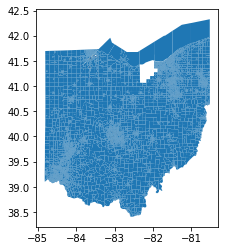

In [103]:
wip_pber_merge.plot()

In [104]:
merge = wip_pber_merge.copy()
election_cols = sorted(list(merge.columns[merge.columns.str.startswith("G")]))
merge["COUNTYNM"] = merge["county"]
merge["COUNTYFP"] = merge["county"].str.lower().map(county_name_to_fips_dict)
merge["PRECINCT"] = merge["UNIQUE_ID"].str.split(pat="-").str[1]
merge[election_cols]=merge[election_cols].fillna(0)
merge_st["geometry"] = merge_st["geometry"].buffer(0)
assert merge[merge.columns[merge.columns.str.startswith("G")]].isna().any().all()==False

merge = merge[["UNIQUE_ID","COUNTYFP","COUNTYNM","PRECINCT","PRECCODE",]+election_cols+["geometry"]]

## Check PBER

In [105]:
#Check that no null values and that UNIQUE precinct identifier is in fact unique
assert merge["UNIQUE_ID"].isna().any()==False
assert merge["UNIQUE_ID"].nunique()==merge.shape[0]


#State, County, Precinct total vote checks adapted from pdv checks: https://github.com/nonpartisan-redistricting-datahub/pdv-resources/blob/main/pdv_functions.py
def statewide_totals_check(partner_df, partner_name, source_df, source_name, column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      difference list
    """
    print("***Statewide Totals Check***")
    diff_races=[]
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            if race not in diff_races:
                diff_races.append(race)
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\t"+ partner_name + ": "+str(partner_df[race].sum())+" votes")
            print("\t"+ source_name +": "+str(source_df[race].sum())+" votes")
        #else:
            #print(race + " is equal", "\t both dataframes " + str(partner_df[race].sum()))
    
    if (len(diff_races)==0):
        print("All contests match statewide!")
    elif (len(diff_races)>0):
        print("Contests with differences: ")
    
    return diff_races


def county_totals_check(partner_df, partner_name, source_df, source_name, column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      partner_name: String of what to call the partner in the print statement
      source_df: DataFrame of election results we are comparing to
      source_name: String of what to call the source in the print statement
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      difference list
    """
    
    print("\n***Countywide Totals Check***")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\t"+ partner_name + ": "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\t"+ source_name +": "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        #else:
            #print(race + " is equal across all counties")
            #if (full_print):
               # for val in diff[diff == 0].index.values.tolist():
                 #   county_similarities = diff[diff == 0]
                    #print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)==0):
        print("All contests in all counties match!")
    elif (len(diff_counties)>0):
        print("Counties with differences: ")
        
    return diff_counties
        
    
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    """Checks a merged dataframe with two election results at the precinct level

    Args:
      merged_df: DataFrame with one set of election results joined to another
      column_list: List of races that there are votes for
      vest_on_left: Boolean specifying whether VEST data is on the left side of merged_df
      name_col: String of the column name to refer to precincts when a difference occurs
      print_level: Integer that specifies how large the vote difference in a precinct must be to be printed

    Returns:
      list of differences
    """
    print("\n***Precinct Totals Check***")
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
            
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1

    print("\nThere are ", len(merged_df.index)," total rows")
    
    if(len(diff_values)!=0):
        print(matching_rows," of these rows are the same")
        print("\nAll precincts containing differences:")
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
        print("\nThe max difference between any one shared column in a row is: ", max_diff)
        count_big_diff = len([i for i in diff_values if i > 10])
        print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    else:
        print(matching_rows," of these rows are the same")
    
    diff_list.sort()
    
    return diff_list
    
    
partner_df = er22.copy()
partner_df["COUNTYNM"] = partner_df["County"].str.upper()
partner_name = "original ER 22"
source_df = merge.copy()
source_name = "PBER 22"
column_list = election_cols
county_col = "COUNTYNM"
#Running inner join because of expected nan value for ZZZ precincts
merged_df = pd.merge(merge, er22, on = ["UNIQUE_ID"], how = "inner", indicator=True)
vest_on_left = False
name_col = "UNIQUE_ID"


#All matches statewide and county levels
statewide_totals_check(partner_df, partner_name, source_df, source_name, column_list)
county_totals_check(partner_df, partner_name, source_df, source_name, column_list,county_col,full_print=False)
precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0)

***Statewide Totals Check***
All contests match statewide!

***Countywide Totals Check***
All contests in all counties match!

***Precinct Totals Check***

There are  8933  total rows
8933  of these rows are the same


[]

## Precinct boundary splits by districts

In [261]:
cong_shp = gp.read_file("./2022_districts/oh_cong_adopted_2022/oh_cong_adopted_2022.shp").to_crs(merge.crs)
cong_shp["CONG_DIST_2"] = cong_shp["CONG_DIST"].copy()
cong_shp = cong_shp.drop("CONG_DIST", axis=1)
sl_shp = gp.read_file("./2022_districts/oh_sldl_adopted_2022/FEB_24_2022_HD_SHP.shp").to_crs(merge.crs)
su_shp = gp.read_file("./2022_districts/oh_sldu_adopted_2022/FEB_24_2022_SD_SHP.shp").to_crs(merge.crs)

merge_for_splits = merge[(~merge["geometry"].isna())&(merge["PRECINCT"]!="ZZZ")].reset_index(drop=True)
merge_st = merge_for_splits[list(merge_for_splits.columns[~(merge_for_splits.columns.str.startswith("GCON"))&~(merge_for_splits.columns.str.startswith("GSL"))&~(merge_for_splits.columns.str.startswith("GSU"))])].reset_index(drop=True)
merge_cong = merge_for_splits[['UNIQUE_ID', 'PRECINCT', 'PRECCODE']+list(merge_for_splits.columns[merge_for_splits.columns.str.startswith("GCON")])+['geometry']].reset_index()
merge_sl = merge_for_splits[['UNIQUE_ID', 'PRECINCT', 'PRECCODE']+list(merge_for_splits.columns[merge_for_splits.columns.str.startswith("GSL")])+['geometry']].reset_index()
merge_su = merge_for_splits[['UNIQUE_ID', 'PRECINCT', 'PRECCODE']+list(merge_for_splits.columns[merge_for_splits.columns.str.startswith("GSU")])+['geometry']].reset_index()

In [216]:
merge_for_splits["G22ATGDCRO"].sum()

1599774.0

In [217]:
merge["G22ATGDCRO"][(~merge["geometry"].isna())].reset_index(drop=True).sum()

1599774.0

In [220]:
merge[merge["geometry"].isna()]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,PRECCODE,G22ATGDCRO,G22ATGRYOS,G22AUDDSAP,G22AUDRFAB,G22CJUDBRU,...,GSU23RSIM,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,geometry
4184,WOOD-NORTHWOOD A,173,WOOD,NORTHWOOD A,ADW,215.0,297.0,223.0,283.0,238.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
8738,LORAIN-PRECINCT AMHERST CITY 1-A,093,LORAIN,PRECINCT AMHERST CITY 1,AAA,305.0,468.0,302.0,454.0,338.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
8739,LORAIN-PRECINCT AMHERST CITY 1-B,093,LORAIN,PRECINCT AMHERST CITY 1,AAB,282.0,424.0,298.0,395.0,315.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
8740,LORAIN-PRECINCT AMHERST CITY 2-A,093,LORAIN,PRECINCT AMHERST CITY 2,AAE,219.0,324.0,226.0,311.0,246.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
8741,LORAIN-PRECINCT AMHERST CITY 2-B,093,LORAIN,PRECINCT AMHERST CITY 2,AAF,206.0,345.0,223.0,321.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8936,LORAIN-PRECINCT LAGRANGE VILL SOUTH,093,LORAIN,PRECINCT LAGRANGE VILL SOUTH,ALS,114.0,302.0,117.0,294.0,137.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
8937,LORAIN-PRECINCT LORAIN CITY 8-H,093,LORAIN,PRECINCT LORAIN CITY 8,ALT,187.0,189.0,197.0,176.0,214.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
8938,LORAIN-PRECINCT N. RIDGEVILLE 1-F,093,LORAIN,PRECINCT N. RIDGEVILLE 1,ALU,270.0,441.0,286.0,418.0,306.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
8939,LORAIN-PRECINCT HENRIETTA TWP #2,093,LORAIN,PRECINCT HENRIETTA TWP #2,ALV,118.0,293.0,126.0,281.0,140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None


### Find Splits

In [112]:
#DETERMINE WHICH PRECINCTS ARE SPLIT
t = time.process_time()
er = er22
er["PREC_CO"] = er["UNIQUE_ID"]
cong_splits = []
sldl_splits = []
sldu_splits = []
cong_split_count = 0
sldl_split_count = 0
sldu_split_count = 0
cong_split_dictionary = {}
sldu_split_dictionary = {}
sldl_split_dictionary = {}

cong_unsplit_dict = {}
sldu_unsplit_dict = {}
sldl_unsplit_dict = {}
no_dists = []
for i in er['PREC_CO']:
    sub = er[er['PREC_CO']==i]
    cong = []
    sldl = []
    sldu = []
    for col in sub.columns:
        if col.startswith('G')&(~col.startswith("G22")):
            col_sum = sub[col].sum()
            if int(col_sum)!= 0:
                if 'GCON' in str(col):
                    cong_dist = str(col).replace('GCON','')[:2]
                    cong.append(cong_dist)
                elif 'GSU' in str(col):
                    sldu_dist = str(col).replace('GSU','')[:2]
                    sldu.append(sldu_dist)
                else:
                    sldl_dist = str(col).replace('GSL','')[:3]
                    sldl.append(sldl_dist)
    cong = list(set(cong))
    sldl = list(set(sldl))
    sldu = list(set(sldu))
    if len(cong)>1:
        print(i, ' is split by congressional district. It is in districts: ', ', '.join(cong))
        cong_splits.append(i)
        cong_split_count+=1
        cong_split_dictionary.update({i:cong})
    if len(cong)==1:
        cong_unsplit_dict.update({i:cong[0]})
    if len(cong) == 0:
        no_dists.append(i)
    if len(sldl)> 1:
        print(i, ' is split by State House district. It is in districts: ', ', '.join(sldl))
        sldl_splits.append(i)
        sldl_split_count+=1
        sldl_split_dictionary.update({i:sldl})
    if len(sldl)==0:
        no_dists.append(i)
    if len(sldl)==1:
        sldl_unsplit_dict.update({i:sldl[0]})
    if len(sldu)> 1:
        print(i, ' is split by State Senate districts. It is in districts: ', ', '.join(sldu))
        sldu_splits.append(i)
        sldu_split_count+=1
        sldu_split_dictionary.update({i:sldu})
    if len(sldu)==0:
        no_dists.append(i)
    if len(sldu)==1:
        sldu_unsplit_dict.update({i:sldu[0]})
no_dists = list(set(no_dists))
print('****************************************************')
print('Congressional split count: ', str(cong_split_count))
print(cong_split_dictionary)
print('SLDU split count: ', str(sldu_split_count))
print(sldu_split_dictionary)
print('SLDL split count: ', str(sldl_split_count))
print(sldl_split_dictionary)
print('***************************************************')
print('There are NO districts associated with the following precincts: ', sorted(no_dists))
print('There are ', str(len(no_dists)), ' that are NOT assigned to a district.')

print('There are ', str(len(er)), ' in the allocated election results file.')

elapsed_time = time.process_time() - t
print("time to run fxn: ", elapsed_time)

BUTLER-HANOVER TWP 7  is split by State House district. It is in districts:  047, 045
BUTLER-MADISON TWP 5  is split by State House district. It is in districts:  046, 040
BUTLER-ROSS TWP 4  is split by State House district. It is in districts:  047, 045
BUTLER-ST CLAIR TWP 2  is split by State House district. It is in districts:  046, 040
BUTLER-ST CLAIR TWP 5  is split by State House district. It is in districts:  046, 047
CLARK-PRECINCT MFLD 9  is split by congressional district. It is in districts:  15, 10
CUYAHOGA-CLEVELAND-01-S  is split by State House district. It is in districts:  022, 018
CUYAHOGA-CLEVELAND-01-R  is split by State House district. It is in districts:  022, 018
CUYAHOGA-CLEVELAND-01-G  is split by State House district. It is in districts:  022, 018
CUYAHOGA-CLEVELAND-06-D  is split by State House district. It is in districts:  020, 018
CUYAHOGA-CLEVELAND-06-D  is split by State Senate districts. It is in districts:  21, 23
CUYAHOGA-CLEVELAND-06-H  is split by St

In [30]:
cong_split_dictionary

{'CLARK-PRECINCT MFLD 9': ['15', '10'],
 'CUYAHOGA-CHAGRIN FALLS-00-A': ['07', '11'],
 'DELAWARE-PRECINCT WESTERVILLE CITY E': ['12', '04'],
 'DELAWARE-PRECINCT GENOA K': ['12', '04'],
 'DELAWARE-PRECINCT GENOA L': ['12', '04'],
 'DELAWARE-PRECINCT GENOA M': ['12', '04'],
 'DELAWARE-PRECINCT WESTERVILLE CITY G': ['12', '04'],
 'DELAWARE-PRECINCT WESTERVILLE CITY H': ['12', '04'],
 'DELAWARE-PRECINCT ORANGE T': ['12', '04'],
 'DELAWARE-PRECINCT WESTERVILLE CITY I': ['12', '04'],
 'FAYETTE-AAS': ['02', '15'],
 'FRANKLIN-AAN': ['15', '03'],
 'FRANKLIN-AGC': ['15', '03'],
 'FRANKLIN-BAQ': ['15', '03'],
 'FRANKLIN-BAR': ['15', '03'],
 'FRANKLIN-BAS': ['15', '03'],
 'HAMILTON-SHARONVILLE 1-A': ['08', '01'],
 'HAMILTON-SHARONVILLE 2-A': ['08', '01'],
 'HAMILTON-SHARONVILLE 3-A': ['08', '01'],
 'HOLMES-AAL': ['07', '12'],
 'HOLMES-AAW': ['07', '12'],
 'MIAMI-PRECINCT CONCORD EAST': ['08', '15'],
 'PORTAGE-PRECINCT SUFFIELD A': ['14', '13'],
 'PORTAGE-PRECINCT SUFFIELD D': ['14', '13'],
 'PORTA

#### Lots of precs w no assignment, how to handle?
On friday I believe we discussed why this was may be ok, but now don't remember the reasoning

In [99]:
## Check if there are precincts left that have no district assigned to them
no_dists_distribute = [i.split('_')[0] for i in no_dists]
print(no_dists_distribute)

['CUYAHOGA-STRONGSVILLE-04-E', 'MONTGOMERY-DAYTON 3-C', 'FAIRFIELD-ACL', 'SANDUSKY-ABM', 'ERIE-PRECINCT GRO TWP', 'WASHINGTON-ACN', 'LUCAS-PRECINCT TOLEDO 8D', 'MORROW-AAY', 'LAKE-PRECINCT MENTOR CITY 4F', 'LAKE-PRECINCT CONCORD TWP D', 'ATHENS-ACD', 'ALLEN-AAJ', 'CLERMONT-UNION TOWNSHIP Q', 'FRANKLIN-BKW', 'BUTLER-HAM1WD1', 'CUYAHOGA-SEVEN HILLS-02-B', 'FRANKLIN-APZ', 'CUYAHOGA-CLEVELAND-13-N', 'JEFFERSON-ABI', 'SUMMIT-ATN', 'MONTGOMERY-WASHINGTON TWP K', 'GREENE-ADR', 'PICKAWAY-CIRCLEVILLE 1-A', 'BUTLER-HAM4WD1', 'MORGAN-AAL', 'MONTGOMERY-DAYTON 21-A', 'PICKAWAY-CIRCLEVILLE 4-A', 'SUMMIT-AHB', 'BELMONT-ABZ', 'MEIGS-AAD', 'ATHENS-ACP', 'CUYAHOGA-STRONGSVILLE-04-B', 'PICKAWAY-WASHINGTON-CENTRAL', 'SCIOTO-ADM', 'MONTGOMERY-DAYTON 18-C', 'GEAUGA-PRECINCT CHARDON TWP C', 'CUYAHOGA-BRECKSVILLE-00-C', 'SANDUSKY-ABZ', 'SCIOTO-ACD', 'FAIRFIELD-ADK', 'ADAMS-ABH', 'JEFFERSON-AAR', 'ASHTABULA-AAX', 'ALLEN-ABH', 'WOOD-BOWLING GREEN 3-B', 'MEDINA-PRECINCT LODI VIL A', 'BELMONT-ACK', 'UNION-ABW', '

In [244]:
len(cong_split_dictionary)

35

In [245]:
len(cong_unsplit_dict)

8898

In [248]:
print(len(sldl_split_dictionary))
print(len(sldl_unsplit_dict))
print(len(sldu_split_dictionary))
print(len(sldu_unsplit_dict))

91
8842
22
4553


### Create gdfs with splits

In [113]:
#generates dataframes with the "lost votes" from splits
def generate_differences_df(df_compare_against, df_compare_to, unique_ID_col, races_list, drop_empty = False):
    
    df_compare_against = df_compare_against[[unique_ID_col]+races_list]
    df_compare_to = df_compare_to[[unique_ID_col]+races_list]
 
    grouped_compare_against = df_compare_against.groupby(unique_ID_col).sum()
    grouped_compare_to = df_compare_to.groupby(unique_ID_col).sum()
    
    grouped_compare_against.reset_index(inplace = True, drop = False)
    grouped_compare_to.reset_index(inplace = True, drop = False)
    diffs = grouped_compare_against.set_index(unique_ID_col).subtract(grouped_compare_to.set_index(unique_ID_col))
    
    diffs["Tot_Votes"] = diffs[races_list].sum(axis=1)
    
    if drop_empty:
        diffs = diffs.loc[~(diffs==0).all(axis=1)]
        diffs = diffs.loc[:, (diffs != 0).any(axis=0)]
    return diffs


def district_splits_comb(level, splits_dict, elections_gdf, district_gdf, unique_ID_col, district_gdf_ID, races_list, elections_gdf_dist_ID, fill_level = 2):
    '''
    Function to split precincts across districts that splits a precinct across the entire district map.
    Previous iterations of this code only split precincts by the districts in which votes were recorded.
    In some instances, that led to holes in the map, due to districts where no votes were recorded in a precinct, but where an intersection occurred.
    '''
    # Intersect the elections gdf with the district gdf
    need_splits = elections_gdf[elections_gdf[unique_ID_col].isin(list(splits_dict.keys()))]
    others = elections_gdf[~elections_gdf[unique_ID_col].isin(list(splits_dict.keys()))]
    
    pre_splits_copy = need_splits.copy(deep = True)
    
    test_join = gp.overlay(need_splits, district_gdf, how = "intersection")
    
    # Assign a district column, using the district shapefile
    test_join[elections_gdf_dist_ID] = test_join[district_gdf_ID]
    
    # Filter the intersection down to the precinct, district pairs we need
    clean_votes = test_join.copy(deep = True)
    
    clean_votes[unique_ID_col+"_new"] = clean_votes[unique_ID_col]
    
    # Remove the others and hold on to these to be merged later
    for index, row in clean_votes.iterrows():
        clean_votes.at[index, unique_ID_col+"_new"] = row[unique_ID_col]+"-("+level + "-" + str(row[district_gdf_ID]).zfill(fill_level) + ")" 
        for column in test_join:
            if column in races_list and str(row[elections_gdf_dist_ID]).zfill(fill_level) not in column:
                clean_votes.at[index, column] = 0 
        
    lost_votes_df = generate_differences_df(pre_splits_copy, clean_votes, unique_ID_col, races_list, True)
    
    clean_votes.drop(unique_ID_col, axis = 1, inplace = True)
    clean_votes.rename(columns = {unique_ID_col+"_new":unique_ID_col}, inplace = True)
    clean_votes = clean_votes[list(others.columns)]
        
    elections_gdf = gp.GeoDataFrame(pd.concat([clean_votes, others]), crs = elections_gdf.crs)
    elections_gdf.reset_index(drop=True,inplace=True)
    
    return elections_gdf, lost_votes_df


def clean_na_dist_assignments(elections_gdf, district_gdf, unique_ID_col, elections_gdf_dist_ID, district_gdf_ID):
    if elections_gdf[elections_gdf[elections_gdf_dist_ID]==0].shape[0]==0:
        return elections_gdf
    
    original_crs = elections_gdf.crs
    elections_gdf = elections_gdf.to_crs(3857)
    
    district_gdf = district_gdf.to_crs(3857)
    
    dist_clean = gp.overlay(elections_gdf[elections_gdf[elections_gdf_dist_ID]==0], district_gdf, how = "intersection")
    dist_clean['area'] = dist_clean.area
    na_assignment_dict = {}
    for val in dist_clean[unique_ID_col].unique():
        assignment = dist_clean.loc[dist_clean[unique_ID_col] == val].nlargest(1, 'area')[district_gdf_ID].values[0]
        na_assignment_dict[val] = assignment
    elections_gdf[elections_gdf_dist_ID] = elections_gdf[unique_ID_col].map(na_assignment_dict).fillna(elections_gdf[elections_gdf_dist_ID])    
    elections_gdf = elections_gdf.to_crs(original_crs)
    
    return elections_gdf

In [203]:
merge_cong["CONG_DIST"] = 0
merge_cong.loc[merge_cong["UNIQUE_ID"].isin(cong_split_dictionary.keys()), "CONG_DIST"] = merge_cong["UNIQUE_ID"].map(cong_split_dictionary)
merge_cong.loc[merge_cong["UNIQUE_ID"].isin(cong_unsplit_dict.keys()), "CONG_DIST"] = merge_cong["UNIQUE_ID"].map(cong_unsplit_dict)
cong_dist_splits = district_splits_comb("CON", cong_split_dictionary, merge_cong, cong_shp, "UNIQUE_ID", "CONG_DIST", list(merge.columns[merge.columns.str.contains("GCON")]), "CONG_DIST_2", fill_level = 2)
cong_elections_df = cong_dist_splits[0]
cong_lost_votes_df = cong_dist_splits[1]


merge_sl["SL_DIST"] = 0
merge_sl.loc[merge_sl["UNIQUE_ID"].isin(sldl_split_dictionary.keys()), "SL_DIST"] = merge_sl["UNIQUE_ID"].map(sldl_split_dictionary)
merge_sl.loc[merge_sl["UNIQUE_ID"].isin(sldl_unsplit_dict.keys()), "SL_DIST"] = merge_sl["UNIQUE_ID"].map(sldl_unsplit_dict)
sl_dist_splits = district_splits_comb("SL", sldl_split_dictionary, merge_sl, sl_shp, "UNIQUE_ID", "SL_DIST", list(merge.columns[merge.columns.str.contains("GSL")]), "DIST", fill_level = 3)
sl_elections_df = sl_dist_splits[0]
sl_lost_votes_df = sl_dist_splits[1]


merge_su["SU_DIST"] = 0
merge_su.loc[merge_su["UNIQUE_ID"].isin(sldu_split_dictionary.keys()), "SU_DIST"] = merge_su["UNIQUE_ID"].map(sldu_split_dictionary)
merge_su.loc[merge_su["UNIQUE_ID"].isin(sldu_unsplit_dict.keys()), "SU_DIST"] = merge_su["UNIQUE_ID"].map(sldu_unsplit_dict)
su_dist_splits = district_splits_comb("SU", sldu_split_dictionary, merge_su, su_shp, "UNIQUE_ID", "SU_DIST", list(merge.columns[merge.columns.str.contains("GSU")]), "DISTRICT", fill_level = 2)
su_elections_df = su_dist_splits[0]
su_lost_votes_df = su_dist_splits[1]

In [288]:
su_elections_df#[su_elections_df["SU_DIST"]==0]

,index,UNIQUE_ID,PRECINCT,PRECCODE,GSU01RMCC,GSU03DMAH,GSU03RREY,GSU05RHUF,GSU07DDAL,GSU07RWIL,...,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,geometry,SU_DIST
0,2124,"CUYAHOGA-CLEVELAND-06-D-(SU-['21', '23'])",CLEVELAND,APL,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.60185 41.50509, -81.60185 ...","[21, 23]"
1,2128,"CUYAHOGA-CLEVELAND-06-H-(SU-['21', '23'])",CLEVELAND,APP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.62314 41.49965, -81.62314 41.499...","[21, 23]"
2,2129,"CUYAHOGA-CLEVELAND-06-I-(SU-['21', '23'])",CLEVELAND,APR,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.62314 41.49965, -81.62455 41.499...","[21, 23]"
3,2141,"CUYAHOGA-CLEVELAND-06-U-(SU-['21', '23'])",CLEVELAND,AUJ,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.60996 41.50152, -81.61010 ...","[21, 23]"
4,2174,"CUYAHOGA-CLEVELAND-08-J-(SU-['21', '23'])",CLEVELAND,AWS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.58506 41.57547, -81.58506 ...","[21, 23]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,PRECINCT SUGAR BUSH KNOLLS,AGE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203...",0
8754,8725,PORTAGE-PRECINCT WINDHAM TWP A,PRECINCT WINDHAM TWP A,AGF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247...",0
8755,8726,PORTAGE-PRECINCT WINDHAM TWP B,PRECINCT WINDHAM TWP B,AGG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272...",0
8756,8727,PORTAGE-PRECINCT WINDHAM VIL A,PRECINCT WINDHAM VIL A,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234...",0


In [205]:
sl_elections_df[sl_elections_df["SL_DIST"]==0]

,index,UNIQUE_ID,PRECINCT,PRECCODE,GSL001DJAR,GSL002DHUM,GSL003DMOH,GSL003RLAN,GSL004DLIG,GSL004RRUD,...,GSL095DRYA,GSL095RJON,GSL096DDIP,GSL096RFER,GSL097RHOL,GSL098RKIC,GSL099DZAP,GSL099RART,geometry,SL_DIST


In [206]:
cong_elections_df[cong_elections_df["CONG_DIST"]==0]

,index,UNIQUE_ID,PRECINCT,PRECCODE,GCON01DLAN,GCON01RCHA,GCON02DMEA,GCON02RWEN,GCON03DBEA,GCON03RSTA,...,GCON12DRIP,GCON12RBAL,GCON13DSYK,GCON13RGIL,GCON14DKIL,GCON14RJOY,GCON15DJOS,GCON15RCAR,geometry,CONG_DIST


In [207]:
#Clean NA DIST Assignments
cleaned_cong_gdf = clean_na_dist_assignments(cong_elections_df, cong_shp, "UNIQUE_ID", "CONG_DIST", "CONG_DIST")
cleaned_sl_gdf = clean_na_dist_assignments(sl_elections_df, sl_shp, "UNIQUE_ID", "SL_DIST", "DIST")
cleaned_su_gdf = clean_na_dist_assignments(su_elections_df, su_shp, "UNIQUE_ID", "SU_DIST", "DISTRICT")

## Check PBER with Splits

In [212]:
#Check that no null values and that UNIQUE precinct identifier is in fact unique
def check_unique_id_unique(merged_gdf):
    assert merged_gdf["UNIQUE_ID"].isna().any()==False
    assert merged_gdf["UNIQUE_ID"].nunique()==merged_gdf.shape[0]
    return "unique_id is unique"


#State, County, Precinct total vote checks adapted from pdv checks: https://github.com/nonpartisan-redistricting-datahub/pdv-resources/blob/main/pdv_functions.py
def statewide_totals_check(partner_df, partner_name, source_df, source_name, column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      difference list
    """
    print("***Statewide Totals Check***")
    diff_races=[]
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            if race not in diff_races:
                diff_races.append(race)
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\t"+ partner_name + ": "+str(partner_df[race].sum())+" votes")
            print("\t"+ source_name +": "+str(source_df[race].sum())+" votes")
        #else:
            #print(race + " is equal", "\t both dataframes " + str(partner_df[race].sum()))
    
    if (len(diff_races)==0):
        print("All contests match statewide!")
    elif (len(diff_races)>0):
        print("Contests with differences: ")
    
    return diff_races


def county_totals_check(partner_df, partner_name, source_df, source_name, column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      partner_name: String of what to call the partner in the print statement
      source_df: DataFrame of election results we are comparing to
      source_name: String of what to call the source in the print statement
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      difference list
    """
    
    print("\n***Countywide Totals Check***")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\t"+ partner_name + ": "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\t"+ source_name +": "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        #else:
            #print(race + " is equal across all counties")
            #if (full_print):
               # for val in diff[diff == 0].index.values.tolist():
                 #   county_similarities = diff[diff == 0]
                    #print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)==0):
        print("All contests in all counties match!")
    elif (len(diff_counties)>0):
        print("Counties with differences: ")
        
    return diff_counties
        
    
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    """Checks a merged dataframe with two election results at the precinct level

    Args:
      merged_df: DataFrame with one set of election results joined to another
      column_list: List of races that there are votes for
      vest_on_left: Boolean specifying whether VEST data is on the left side of merged_df
      name_col: String of the column name to refer to precincts when a difference occurs
      print_level: Integer that specifies how large the vote difference in a precinct must be to be printed

    Returns:
      list of differences
    """
    print("\n***Precinct Totals Check***")
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
            
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1

    print("\nThere are ", len(merged_df.index)," total rows")
    
    if(len(diff_values)!=0):
        print(matching_rows," of these rows are the same")
        print("\nAll precincts containing differences:")
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
        print("\nThe max difference between any one shared column in a row is: ", max_diff)
        count_big_diff = len([i for i in diff_values if i > 10])
        print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    else:
        print(matching_rows," of these rows are the same")
    
    diff_list.sort()
    
    return diff_list


def run_all_checks(partner_df, partner_name, source_df, source_name, column_list,county_col,full_print=False, prec_check=True):
    check_unique_id_unique(source_df)
    #Running inner join because of expected nan value for ZZZ precincts
    merged_df = pd.merge(source_df, partner_df, on = ["UNIQUE_ID"], how = "inner", indicator=True)
    vest_on_left = False
    name_col = "UNIQUE_ID"
    #All matches statewide and county levels
    statewide_totals_check(partner_df, partner_name, source_df, source_name, column_list)
    county_totals_check(partner_df, partner_name, source_df, source_name, column_list,county_col,full_print=False)
    if prec_check ==True:
        precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0)


In [234]:
check_unique_id_unique(source_df)
#Running inner join because of expected nan value for ZZZ precincts
merged_df = pd.merge(source_df, partner_df, on = ["UNIQUE_ID"], how = "inner", indicator=True)
vest_on_left = False
name_col = "UNIQUE_ID"
#All matches statewide and county levels
statewide_totals_check(partner_df, partner_name, cleaned_cong_gdf, "cong", list(cleaned_cong_gdf[cleaned_cong_gdf.columns.str.startswith("G")]))
county_totals_check(partner_df, partner_name, cleaned_cong_gdf, "cong", list(cleaned_cong_gdf[cleaned_cong_gdf.columns.str.startswith("G")]),county_col,full_print=False)



ValueError: Item wrong length 36 instead of 8765.

In [235]:
partner_df = er22.copy()
print("remove line 3 once LORAIN added in")
partner_df = partner_df[(partner_df["UNIQUE_ID"]!="WOOD-NORTHWOOD A")&(partner_df["County"]!="Lorain")]
partner_df["COUNTYNM"] = partner_df["County"].str.upper()
partner_name = "original ER 22"

source_df = merge.copy()
source_name = "PBER 22"
county_col = "COUNTYNM"

print("checking statewide gdf:")
run_all_checks(partner_df, partner_name, merge_st, "st gdf", list(merge_st.columns[merge_st.columns.str.startswith("G")]),county_col,full_print=False, prec_check=True)
#print("checking cong w splits gdf:")
#run_all_checks(partner_df, partner_name, cleaned_cong_gdf, "cong split", list(cleaned_cong_gdf[cleaned_cong_gdf.columns.str.startswith("G")]),county_col,full_print=False, prec_check=False)
#print("checking sldl w splits gdf:")
#run_all_checks(partner_df, partner_name, cleaned_sl_gdf, "sl split", list(cleaned_sl_gdf[cleaned_sl_gdf.columns.str.startswith("G")]),county_col,full_print=False, prec_check=False)
#print("checking sldu w splits gdf")
#run_all_checks(partner_df, partner_name, cleaned_su_gdf, "su split", list(cleaned_su_gdf[cleaned_su_gdf.columns.str.startswith("G")]),county_col,full_print=False, prec_check=False)


remove line 3 once LORAIN added in
checking sldl w splits gdf:


ValueError: Item wrong length 177 instead of 8854.

## Export precinct shps

### Statewide file

In [109]:
merge_st

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,PRECCODE,G22ATGDCRO,G22ATGRYOS,G22AUDDSAP,G22AUDRFAB,G22CJUDBRU,...,G22JUSRDEW,G22JUSRFIS,G22SOSDCLA,G22SOSOMAR,G22SOSRLAR,G22TREDSCH,G22TRERSPR,G22USSDRYA,G22USSRVAN,geometry
0,CLARK-PRECINCT BETH 1,023,CLARK,PRECINCT BETH 1,ADF,158.0,554.0,168.0,551.0,191.0,...,537.0,534.0,171.0,8.0,542.0,179.0,534.0,211.0,509.0,"POLYGON ((-83.99403 39.88828, -83.99342 39.886..."
1,CLARK-PRECINCT BETH 2,023,CLARK,PRECINCT BETH 2,ADG,140.0,445.0,148.0,443.0,151.0,...,439.0,434.0,143.0,6.0,442.0,143.0,447.0,161.0,429.0,"POLYGON ((-84.02445 39.88394, -84.02425 39.883..."
2,CLARK-PRECINCT BETH 3,023,CLARK,PRECINCT BETH 3,ADH,143.0,458.0,158.0,449.0,167.0,...,445.0,447.0,151.0,6.0,452.0,148.0,459.0,172.0,428.0,"MULTIPOLYGON (((-84.03757 39.88836, -84.03750 ..."
3,CLARK-PRECINCT BETH 4,023,CLARK,PRECINCT BETH 4,ADI,162.0,674.0,172.0,659.0,191.0,...,649.0,648.0,170.0,15.0,659.0,186.0,648.0,228.0,611.0,"POLYGON ((-84.04138 39.93745, -84.04145 39.937..."
4,CLARK-PRECINCT BETH 5,023,CLARK,PRECINCT BETH 5,ADJ,201.0,527.0,207.0,517.0,220.0,...,509.0,505.0,197.0,8.0,531.0,213.0,513.0,253.0,482.0,"POLYGON ((-83.96907 39.93094, -83.96726 39.930..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,133,PORTAGE,PRECINCT SUGAR BUSH KNOLLS,AGE,68.0,72.0,65.0,72.0,73.0,...,67.0,67.0,68.0,0.0,71.0,68.0,69.0,74.0,65.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203..."
8725,PORTAGE-PRECINCT WINDHAM TWP A,133,PORTAGE,PRECINCT WINDHAM TWP A,AGF,62.0,193.0,68.0,183.0,79.0,...,178.0,179.0,70.0,5.0,182.0,69.0,184.0,82.0,172.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247..."
8726,PORTAGE-PRECINCT WINDHAM TWP B,133,PORTAGE,PRECINCT WINDHAM TWP B,AGG,103.0,281.0,108.0,271.0,122.0,...,262.0,263.0,106.0,3.0,275.0,114.0,261.0,131.0,255.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272..."
8727,PORTAGE-PRECINCT WINDHAM VIL A,133,PORTAGE,PRECINCT WINDHAM VIL A,AGH,53.0,92.0,61.0,83.0,60.0,...,79.0,85.0,54.0,2.0,88.0,62.0,83.0,70.0,74.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234..."


In [242]:
cleaned_cong_gdf

,index,UNIQUE_ID,PRECINCT,PRECCODE,GCON01DLAN,GCON01RCHA,GCON02DMEA,GCON02RWEN,GCON03DBEA,GCON03RSTA,...,GCON12DRIP,GCON12RBAL,GCON13DSYK,GCON13RGIL,GCON14DKIL,GCON14RJOY,GCON15DJOS,GCON15RCAR,geometry,CONG_DIST
0,56,"CLARK-PRECINCT MFLD 9-(CON-['15', '10'])",PRECINCT MFLD 9,AEW,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-83.77925 39.96637, -83.77995 ...","[15, 10]"
1,56,"CLARK-PRECINCT MFLD 9-(CON-['15', '10'])",PRECINCT MFLD 9,AEW,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-83.78437 39.97498, -83.78440 ...","[15, 10]"
2,2925,"MIAMI-PRECINCT CONCORD EAST-(CON-['15', '08'])",PRECINCT CONCORD EAST,ABY,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON Z (((-84.18529 40.01431 0.00000, ...","[15, 08]"
3,4260,"SHELBY-ACG-(CON-['15', '04'])",ACG,ACG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-84.20903 40.34590, -84.20902 40.345...","[15, 04]"
4,4731,"FAYETTE-AAS-(CON-['02', '15'])",AAS,AAS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-83.58772 39.41528, -83.58679 39.426...","[02, 15]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8760,8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,PRECINCT SUGAR BUSH KNOLLS,AGE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,69.0,71.0,0.0,0.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203...",14
8761,8725,PORTAGE-PRECINCT WINDHAM TWP A,PRECINCT WINDHAM TWP A,AGF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,65.0,190.0,0.0,0.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247...",14
8762,8726,PORTAGE-PRECINCT WINDHAM TWP B,PRECINCT WINDHAM TWP B,AGG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,107.0,274.0,0.0,0.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272...",14
8763,8727,PORTAGE-PRECINCT WINDHAM VIL A,PRECINCT WINDHAM VIL A,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,83.0,0.0,0.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234...",14


In [236]:
#Isolate elections without districts/split precincts
#WILL NEED TO RE-RUN FOR LORAIN
merge_st.to_file("./oh_2022_gen_prec_shp_wip/oh_2022_gen_prec_st.shp")
cleaned_cong_gdf.to_file("./oh_2022_gen_prec_shp_wip/oh_2022_gen_prec_cong.shp")
cleaned_sl_gdf.to_file("./oh_2022_gen_prec_shp_wip/oh_2022_gen_prec_sldl.shp")
cleaned_su_gdf.to_file("./oh_2022_gen_prec_shp_wip/oh_2022_gen_prec_sldu.shp")

ValueError: Invalid field type <class 'list'>

## Save for later

### LF district assign code:

In [180]:
cong_shp = gp.read_file("./2022_districts/oh_cong_adopted_2022/oh_cong_adopted_2022.shp").to_crs(merge.crs)
sl_shp = gp.read_file("./2022_districts/oh_sldl_adopted_2022/FEB_24_2022_HD_SHP.shp").to_crs(merge.crs)
su_shp = gp.read_file("./2022_districts/oh_sldu_adopted_2022/FEB_24_2022_SD_SHP.shp").to_crs(merge.crs)

merge_for_splits = merge[(~merge["geometry"].isna())&(merge["PRECINCT"]!="ZZZ")].reset_index(drop=True)
merge_st = merge_for_splits[list(merge_for_splits.columns[~(merge_for_splits.columns.str.startswith("GCON"))&~(merge_for_splits.columns.str.startswith("GSL"))&~(merge_for_splits.columns.str.startswith("GSU"))])].reset_index(drop=True)
merge_cong = merge_for_splits[['UNIQUE_ID', 'PRECINCT', 'PRECCODE']+list(merge_for_splits.columns[merge_for_splits.columns.str.startswith("GCON")])+['geometry']].reset_index()
merge_sl = merge_for_splits[['UNIQUE_ID', 'PRECINCT', 'PRECCODE']+list(merge_for_splits.columns[merge_for_splits.columns.str.startswith("GSL")])+['geometry']].reset_index()
merge_su = merge_for_splits[['UNIQUE_ID', 'PRECINCT', 'PRECCODE']+list(merge_for_splits.columns[merge_for_splits.columns.str.startswith("GSU")])+['geometry']].reset_index()

In [271]:
def get_contest_dist_dict(df, contest):
    if contest =="GCON":
        col_to_dist_dict = pd.Series(df.columns[df.columns.str.startswith(contest)].str.slice(start=4,stop=6).values, index=df.columns[df.columns.str.startswith(contest)]).to_dict()
    elif contest =="GSL":
        col_to_dist_dict = pd.Series(df.columns[df.columns.str.startswith(contest)].str.slice(start=3,stop=6).values, index=df.columns[df.columns.str.startswith(contest)]).to_dict()
    elif contest =="GSU":
        col_to_dist_dict = pd.Series(df.columns[df.columns.str.startswith(contest)].str.slice(start=3,stop=5).values, index=df.columns[df.columns.str.startswith(contest)]).to_dict()
    
    return col_to_dist_dict


def get_prec_to_dist_list_dict(df, contest):
    col_dist_dict = get_contest_dist_dict(df, contest)
    df["DIST"] = 0
    #Instead of iterating over columns, iterate over districts?
    for col in df.columns[df.columns.str.startswith(contest)]:
        df.loc[(df[col]>0)&(df["DIST"]==0), "DIST"] = col_dist_dict.get(col)

        df.loc[(df[col]>0)&(df["DIST"]!=0), "DIST"] = df["DIST"][(df[col]>0)]+", "+col_dist_dict.get(col)
    
    dist_list_dict = pd.Series(df["DIST"].values, index=df["UNIQUE_ID"])
    
    return dist_list_dict



def get_df_with_split_prec_indicator(df, contest):
    t = time.process_time()
    
    df["DIST"] = df["UNIQUE_ID"].map(get_prec_to_dist_list_dict(df, contest))
    
    df["DIST_index"]=0
    df["DIST_len_assignment"]=0
    index_to_set_dict = {}
    index_to_len_dict = {}

    #8933=Len of gdf outside of ZZZ precs//keeping as much as possible out of for loop for speed
    for i in range(0,len(df[df["DIST"]!=0])-1):
        df["DIST_index"].loc[i] = i
        if df.loc[i,"DIST"]==0:
            district_list = [0]
            index_to_len_dict[i] = 0
        else:
            district_list = list(set(df.loc[i,"DIST"].split(", ")))
            index_to_len_dict[i] = len(district_list)
        index_to_set_dict[i] = district_list
        
        if len(district_list)==1:
            district_item = district_list[0]
            index_to_set_dict[i] = district_item
    df["DIST_set"] = df["DIST_index"].map(index_to_set_dict)
   
    df["DIST_len_assignment"] = df["DIST_index"].map(index_to_len_dict)
    prec_to_dist_dict = pd.Series(df["DIST_set"].values, index = df["UNIQUE_ID"])
    
    elapsed_time = time.process_time() - t
    print("time to run fxn: ", elapsed_time)
    
    return df, prec_to_dist_dict

In [263]:
#Grab splits
cong_pber = merge_cong.copy()
cong_pber_splits = get_df_with_split_prec_indicator(cong_pber, "GCON")
cong_pber_splits_gdf = cong_pber_splits[0]
cong_pber_splits_gdf["CONG_DIST"] = 0
cong_pber_splits_gdf["CONG_DIST"] = cong_pber_splits_gdf["UNIQUE_ID"].map(cong_pber_splits[1])
cong_splits_dict = pd.Series(cong_pber_splits_gdf["CONG_DIST"][cong_pber_splits_gdf["DIST_len_assignment"]>1].values, index = cong_pber_splits_gdf["UNIQUE_ID"][cong_pber_splits_gdf["DIST_len_assignment"]>1]).to_dict()


sl_pber_splits = get_df_with_split_prec_indicator(merge_sl, "GSL")
sl_pber_splits_gdf = sl_pber_splits[0]
sl_pber_splits_gdf["SL_DIST"] = 0
sl_pber_splits_gdf["SL_DIST"] = sl_pber_splits_gdf["UNIQUE_ID"].map(sl_pber_splits[1])
sl_splits_dict = pd.Series(sl_pber_splits_gdf["SL_DIST"][sl_pber_splits_gdf["DIST_len_assignment"]>1].values, index = sl_pber_splits_gdf["UNIQUE_ID"][sl_pber_splits_gdf["DIST_len_assignment"]>1]).to_dict()


#Create gdfs with split geometries
lf_cong_splits = district_splits_comb("CON", cong_splits_dict, cong_pber_splits_gdf, cong_shp, "UNIQUE_ID", "CONG_DIST", list(merge.columns[merge.columns.str.contains("GCON")]), "CONG_DIST_2", fill_level = 2)
lf_cong_ergdf = lf_cong_splits[0]
lf_cong_lost_votes = lf_cong_splits[1]

lf_sl_dist_splits = district_splits_comb("SL", sl_splits_dict, sl_pber_splits_gdf, sl_shp, "UNIQUE_ID", "SL_DIST", list(merge.columns[merge.columns.str.contains("GSL")]), "DIST", fill_level = 3)
lf_sl_elections_df = sl_dist_splits[0]
lf_sl_lost_votes_df = sl_dist_splits[1]

time to run fxn:  0.5962020000000052
time to run fxn:  0.8250120000000152


In [272]:
su_pber_splits = get_df_with_split_prec_indicator(merge_su, "GSU")
su_pber_splits_gdf = su_pber_splits[0]
su_pber_splits_gdf["SU_DIST"] = 0
su_pber_splits_gdf["SU_DIST"] = su_pber_splits_gdf["UNIQUE_ID"].map(su_pber_splits[1])
su_splits_dict = pd.Series(su_pber_splits_gdf["SU_DIST"][su_pber_splits_gdf["DIST_len_assignment"]>1].values, index = su_pber_splits_gdf["UNIQUE_ID"][su_pber_splits_gdf["DIST_len_assignment"]>1]).to_dict()

lf_su_dist_splits = district_splits_comb("SU", su_splits_dict, su_pber_splits_gdf, su_shp, "UNIQUE_ID", "SU_DIST", list(merge.columns[merge.columns.str.contains("GSU")]), "DIST", fill_level = 2)
lf_su_elections_df = su_dist_splits[0]
lf_su_lost_votes_df = su_dist_splits[1]

time to run fxn:  0.33277200000003404


In [273]:
lf_su_elections_df[""]

,index,UNIQUE_ID,PRECINCT,PRECCODE,GSU01RMCC,GSU03DMAH,GSU03RREY,GSU05RHUF,GSU07DDAL,GSU07RWIL,...,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,geometry,SU_DIST
0,2124,"CUYAHOGA-CLEVELAND-06-D-(SU-['21', '23'])",CLEVELAND,APL,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.60185 41.50509, -81.60185 ...","[21, 23]"
1,2128,"CUYAHOGA-CLEVELAND-06-H-(SU-['21', '23'])",CLEVELAND,APP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.62314 41.49965, -81.62314 41.499...","[21, 23]"
2,2129,"CUYAHOGA-CLEVELAND-06-I-(SU-['21', '23'])",CLEVELAND,APR,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.62314 41.49965, -81.62455 41.499...","[21, 23]"
3,2141,"CUYAHOGA-CLEVELAND-06-U-(SU-['21', '23'])",CLEVELAND,AUJ,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.60996 41.50152, -81.61010 ...","[21, 23]"
4,2174,"CUYAHOGA-CLEVELAND-08-J-(SU-['21', '23'])",CLEVELAND,AWS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.58506 41.57547, -81.58506 ...","[21, 23]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,PRECINCT SUGAR BUSH KNOLLS,AGE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203...",0
8754,8725,PORTAGE-PRECINCT WINDHAM TWP A,PRECINCT WINDHAM TWP A,AGF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247...",0
8755,8726,PORTAGE-PRECINCT WINDHAM TWP B,PRECINCT WINDHAM TWP B,AGG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272...",0
8756,8727,PORTAGE-PRECINCT WINDHAM VIL A,PRECINCT WINDHAM VIL A,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234...",0


In [287]:
su_elections_df["SU_DIST"].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


0           4357
17           335
21           311
33           308
05           287
23           287
01           287
27           285
07           269
19           260
29           256
31           256
11           246
03           238
09           229
15           229
25           227
13            40
[15, 03]      18
[25, 03]      12
[21, 23]      10
[15, 25]       7
[29, 31]       4
Name: SU_DIST, dtype: int64

In [282]:
len(su_shp["DISTRICT"].unique())

33

In [275]:
sl_elections_df

,index,UNIQUE_ID,PRECINCT,PRECCODE,GSL001DJAR,GSL002DHUM,GSL003DMOH,GSL003RLAN,GSL004DLIG,GSL004RRUD,...,GSL095DRYA,GSL095RJON,GSL096DDIP,GSL096RFER,GSL097RHOL,GSL098RKIC,GSL099DZAP,GSL099RART,geometry,SL_DIST
0,393,"GEAUGA-PRECINCT MIDDLEFIELD TWP A-(SL-['035', ...",PRECINCT MIDDLEFIELD TWP A,ABV,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.05128 41.44832, -81.05128 ...","[035, 099]"
1,393,"GEAUGA-PRECINCT MIDDLEFIELD TWP A-(SL-['035', ...",PRECINCT MIDDLEFIELD TWP A,ABV,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.09531 41.47134, -81.09534 ...","[035, 099]"
2,6430,"SUMMIT-AVH-(SL-['035', '032'])",AVH,AVH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.42390 41.04486, -81.42390 ...","[035, 032]"
3,6641,"SUMMIT-ASP-(SL-['035', '032'])",ASP,ASP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.58903 40.98984, -81.58901 40.992...","[035, 032]"
4,1529,"BUTLER-HANOVER TWP 7-(SL-['047', '045'])",HANOVER TWP 7,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-84.60421 39.39158, -84.60421 ...","[047, 045]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8849,8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,PRECINCT SUGAR BUSH KNOLLS,AGE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203...",072
8850,8725,PORTAGE-PRECINCT WINDHAM TWP A,PRECINCT WINDHAM TWP A,AGF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247...",035
8851,8726,PORTAGE-PRECINCT WINDHAM TWP B,PRECINCT WINDHAM TWP B,AGG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272...",035
8852,8727,PORTAGE-PRECINCT WINDHAM VIL A,PRECINCT WINDHAM VIL A,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234...",035


In [276]:
merge_sl

,index,UNIQUE_ID,PRECINCT,PRECCODE,GSL001DJAR,GSL002DHUM,GSL003DMOH,GSL003RLAN,GSL004DLIG,GSL004RRUD,...,GSL097RHOL,GSL098RKIC,GSL099DZAP,GSL099RART,geometry,DIST,DIST_index,DIST_len_assignment,DIST_set,SL_DIST
0,0,CLARK-PRECINCT BETH 1,PRECINCT BETH 1,ADF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-83.99403 39.88828, -83.99342 39.886...","074, 074, 074",0,1,074,074
1,1,CLARK-PRECINCT BETH 2,PRECINCT BETH 2,ADG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-84.02445 39.88394, -84.02425 39.883...","074, 074, 074",1,1,074,074
2,2,CLARK-PRECINCT BETH 3,PRECINCT BETH 3,ADH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-84.03757 39.88836, -84.03750 ...","074, 074, 074",2,1,074,074
3,3,CLARK-PRECINCT BETH 4,PRECINCT BETH 4,ADI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-84.04138 39.93745, -84.04145 39.937...","074, 074, 074",3,1,074,074
4,4,CLARK-PRECINCT BETH 5,PRECINCT BETH 5,ADJ,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-83.96907 39.93094, -83.96726 39.930...","074, 074, 074",4,1,074,074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8724,8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,PRECINCT SUGAR BUSH KNOLLS,AGE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203...","072, 072, 072",8724,1,072,072
8725,8725,PORTAGE-PRECINCT WINDHAM TWP A,PRECINCT WINDHAM TWP A,AGF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247...","035, 035, 035",8725,1,035,035
8726,8726,PORTAGE-PRECINCT WINDHAM TWP B,PRECINCT WINDHAM TWP B,AGG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272...","035, 035, 035",8726,1,035,035
8727,8727,PORTAGE-PRECINCT WINDHAM VIL A,PRECINCT WINDHAM VIL A,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234...","035, 035, 035",8727,1,035,035


In [249]:
get_prec_to_dist_list_dict(merge_su, "GSU")

UNIQUE_ID
CLARK-PRECINCT BETH 1                 0
CLARK-PRECINCT BETH 2                 0
CLARK-PRECINCT BETH 3                 0
CLARK-PRECINCT BETH 4                 0
CLARK-PRECINCT BETH 5                 0
                                     ..
PORTAGE-PRECINCT SUGAR BUSH KNOLLS    0
PORTAGE-PRECINCT WINDHAM TWP A        0
PORTAGE-PRECINCT WINDHAM TWP B        0
PORTAGE-PRECINCT WINDHAM VIL A        0
PORTAGE-PRECINCT WINDHAM VIL B        0
Length: 8729, dtype: object

In [254]:
#get_contest_dist_dict(merge_su, "GSU")

col_dist_dict = get_contest_dist_dict(merge_su, "GSU")
merge_su["DIST"] = 0
#Instead of iterating over columns, iterate over districts?
for col in merge_su.columns[merge_su.columns.str.startswith("GSU")]:
    merge_su.loc[(merge_su[col]>0)&(merge_su["DIST"]==0), "DIST"] = col_dist_dict.get(col)

    merge_su.loc[(merge_su[col]>0)&(merge_su["DIST"]!=0), "DIST"] = merge_su["DIST"][(merge_su[col]>0)]+", "+col_dist_dict.get(col)

su_list_dict = pd.Series(merge_su["DIST"].values, index=merge_su["UNIQUE_ID"])

In [257]:
set(su_list_dict.values)

{0,
 '01, 01',
 '03, 03, 03',
 '03, 03, 03, 15',
 '03, 03, 03, 25, 25',
 '03, 03, 15',
 '05, 05',
 '07, 07',
 '07, 07, 07',
 '09, 09, 09',
 '11, 11, 11',
 '13, 13, 13',
 '15, 15',
 '15, 15, 25, 25',
 '17, 17, 17',
 '19, 19, 19',
 '21, 21',
 '21, 21, 21',
 '21, 21, 21, 23, 23',
 '21, 21, 23, 23',
 '23, 23, 23',
 '25, 25, 25',
 '27, 27',
 '27, 27, 27',
 '29, 29',
 '29, 29, 31',
 '31, 31',
 '33, 33, 33'}

In [258]:
col_dist_dict

{'GSU01RMCC': '01',
 'GSU03DMAH': '03',
 'GSU03RREY': '03',
 'GSU05RHUF': '05',
 'GSU07DDAL': '07',
 'GSU07RWIL': '07',
 'GSU09DING': '09',
 'GSU09RSON': '09',
 'GSU11DHIC': '11',
 'GSU11RDIA': '11',
 'GSU13DELI': '13',
 'GSU13RMAN': '13',
 'GSU15DCRA': '15',
 'GSU17DBOO': '17',
 'GSU17RWIL': '17',
 'GSU19DSWI': '19',
 'GSU19RBRE': '19',
 'GSU21DSMI': '21',
 'GSU21RALT': '21',
 'GSU23DANT': '23',
 'GSU23RSIM': '23',
 'GSU25DDEM': '25',
 'GSU25RWYS': '25',
 'GSU27DGOE': '27',
 'GSU27RROE': '27',
 'GSU29RSCH': '29',
 'GSU31RLAN': '31',
 'GSU33DHAG': '33',
 'GSU33RRUL': '33'}

In [250]:
merge_su

,index,UNIQUE_ID,PRECINCT,PRECCODE,GSU01RMCC,GSU03DMAH,GSU03RREY,GSU05RHUF,GSU07DDAL,GSU07RWIL,...,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,geometry,SU_DIST,DIST
0,0,CLARK-PRECINCT BETH 1,PRECINCT BETH 1,ADF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-83.99403 39.88828, -83.99342 39.886...",0,0
1,1,CLARK-PRECINCT BETH 2,PRECINCT BETH 2,ADG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-84.02445 39.88394, -84.02425 39.883...",0,0
2,2,CLARK-PRECINCT BETH 3,PRECINCT BETH 3,ADH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-84.03757 39.88836, -84.03750 ...",0,0
3,3,CLARK-PRECINCT BETH 4,PRECINCT BETH 4,ADI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-84.04138 39.93745, -84.04145 39.937...",0,0
4,4,CLARK-PRECINCT BETH 5,PRECINCT BETH 5,ADJ,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-83.96907 39.93094, -83.96726 39.930...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8724,8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,PRECINCT SUGAR BUSH KNOLLS,AGE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203...",0,0
8725,8725,PORTAGE-PRECINCT WINDHAM TWP A,PRECINCT WINDHAM TWP A,AGF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247...",0,0
8726,8726,PORTAGE-PRECINCT WINDHAM TWP B,PRECINCT WINDHAM TWP B,AGG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272...",0,0
8727,8727,PORTAGE-PRECINCT WINDHAM VIL A,PRECINCT WINDHAM VIL A,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234...",0,0


In [168]:
su_pber_splits_gdf

,index,UNIQUE_ID,PRECINCT,PRECCODE,GCON01DLAN,GCON01RCHA,GCON02DMEA,GCON02RWEN,GCON03DBEA,GCON03RSTA,...,GCON15DJOS,GCON15RCAR,geometry,DIST,DIST_index,DIST_len_assignment,DIST_set,CONG_DIST,SL_DIST,SU_DIST
0,0,CLARK-PRECINCT BETH 1,PRECINCT BETH 1,ADF,0.0,0.0,0.0,0.0,0.0,0.0,...,178.0,540.0,"POLYGON ((-83.99403 39.88828, -83.99342 39.886...",0,0,NaN,NaN,15,NaN,NaN
1,1,CLARK-PRECINCT BETH 2,PRECINCT BETH 2,ADG,0.0,0.0,0.0,0.0,0.0,0.0,...,147.0,444.0,"POLYGON ((-84.02445 39.88394, -84.02425 39.883...",0,0,NaN,NaN,15,NaN,NaN
2,2,CLARK-PRECINCT BETH 3,PRECINCT BETH 3,ADH,0.0,0.0,0.0,0.0,0.0,0.0,...,158.0,448.0,"MULTIPOLYGON (((-84.03757 39.88836, -84.03750 ...",0,0,NaN,NaN,15,NaN,NaN
3,3,CLARK-PRECINCT BETH 4,PRECINCT BETH 4,ADI,0.0,0.0,0.0,0.0,0.0,0.0,...,192.0,641.0,"POLYGON ((-84.04138 39.93745, -84.04145 39.937...",0,0,NaN,NaN,15,NaN,NaN
4,4,CLARK-PRECINCT BETH 5,PRECINCT BETH 5,ADJ,0.0,0.0,0.0,0.0,0.0,0.0,...,215.0,512.0,"POLYGON ((-83.96907 39.93094, -83.96726 39.930...",0,0,NaN,NaN,15,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8724,8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,PRECINCT SUGAR BUSH KNOLLS,AGE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203...",0,0,NaN,NaN,14,NaN,NaN
8725,8725,PORTAGE-PRECINCT WINDHAM TWP A,PRECINCT WINDHAM TWP A,AGF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247...",0,0,NaN,NaN,14,NaN,NaN
8726,8726,PORTAGE-PRECINCT WINDHAM TWP B,PRECINCT WINDHAM TWP B,AGG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272...",0,0,NaN,NaN,14,NaN,NaN
8727,8727,PORTAGE-PRECINCT WINDHAM VIL A,PRECINCT WINDHAM VIL A,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234...",0,0,NaN,NaN,14,NaN,NaN


In [178]:
su_elections_df.sum()

index                                                 38286340
UNIQUE_ID    CUYAHOGA-CLEVELAND-06-D-(SU-['21', '23'])CUYAH...
PRECINCT     CLEVELANDCLEVELANDCLEVELANDCLEVELANDCLEVELANDC...
PRECCODE     APLAPPAPRAUJAWSAPLAPPAPRAUJAWSALNANYALNANYAYMA...
GSU01RMCC                                             104274.0
GSU03DMAH                                              55049.0
GSU03RREY                                              60376.0
GSU05RHUF                                              99741.0
GSU07DDAL                                              59563.0
GSU07RWIL                                              95414.0
GSU09DING                                              78639.0
GSU09RSON                                              29418.0
GSU11DHIC                                              64761.0
GSU11RDIA                                              52384.0
GSU13DELI                                               6044.0
GSU13RMAN                                              

In [188]:
sldu_split_dictionary

{'CUYAHOGA-CLEVELAND-06-D': ['21', '23'],
 'CUYAHOGA-CLEVELAND-06-H': ['21', '23'],
 'CUYAHOGA-CLEVELAND-06-I': ['21', '23'],
 'CUYAHOGA-CLEVELAND-06-U': ['21', '23'],
 'CUYAHOGA-CLEVELAND-08-J': ['21', '23'],
 'FRANKLIN-ACB': ['15', '25'],
 'FRANKLIN-ACC': ['15', '25'],
 'FRANKLIN-AYJ': ['25', '03'],
 'FRANKLIN-AYM': ['25', '03'],
 'FRANKLIN-AYX': ['15', '03'],
 'FRANKLIN-BAJ': ['15', '25'],
 'FRANKLIN-BAV': ['25', '03'],
 'FRANKLIN-BBH': ['15', '03'],
 'FRANKLIN-BBJ': ['15', '03'],
 'FRANKLIN-BBP': ['15', '03'],
 'FRANKLIN-BBR': ['25', '03'],
 'FRANKLIN-BBT': ['15', '03'],
 'FRANKLIN-BIQ': ['15', '03'],
 'FRANKLIN-BLC': ['25', '03'],
 'FRANKLIN-BLY': ['15', '03'],
 'STARK-PERRY 4': ['29', '31'],
 'STARK-TUSCARAWAS 2': ['29', '31']}

In [189]:
sldu_unsplit_dict

{'BUTLER-TRENTON 1': '05',
 'BUTLER-TRENTON 2': '05',
 'BUTLER-TRENTON 3': '05',
 'BUTLER-TRENTON 4': '05',
 'BUTLER-TRENTON 5': '05',
 'BUTLER-TRENTON 6': '05',
 'BUTLER-TRENTON 7': '05',
 'BUTLER-MADISON TWP 5': '05',
 'BUTLER-MILFORD TWP 1': '05',
 'BUTLER-MILFORD TWP 2': '05',
 'BUTLER-ST CLAIR TWP 2': '05',
 'BUTLER-WAYNE TWP 1': '05',
 'BUTLER-WAYNE TWP 2': '05',
 'BUTLER-WAYNE TWP 3': '05',
 'BUTLER-WAYNE TWP 4': '05',
 'BUTLER-WAYNE TWP 5': '05',
 'BUTLER-TRENTON 8': '05',
 'CARROLL-AAA': '33',
 'CARROLL-AAC': '33',
 'CARROLL-AAE': '33',
 'CARROLL-AAF': '33',
 'CARROLL-AAG': '33',
 'CARROLL-AAJ': '33',
 'CARROLL-AAL': '33',
 'CARROLL-AAO': '33',
 'CARROLL-AAQ': '33',
 'CARROLL-AAR': '33',
 'CARROLL-AAV': '33',
 'CARROLL-AAW': '33',
 'CARROLL-AAX': '33',
 'CARROLL-AAY': '33',
 'CARROLL-AAZ': '33',
 'CARROLL-ABB': '33',
 'CARROLL-ABD': '33',
 'CARROLL-ABE': '33',
 'CARROLL-ABG': '33',
 'CARROLL-ABH': '33',
 'CARROLL-ABJ': '33',
 'CARROLL-ABK': '33',
 'CARROLL-ABL': '33',
 'COLUMB

In [186]:
no_dists

['ADAMS-AAA',
 'MERCER-FRANKLIN EAST',
 'SANDUSKY-ABA',
 'SCIOTO-ABW',
 'ERIE-PRECINCT SAN N',
 'MEDINA-PRECINCT MONTVILLE I',
 'PORTAGE-PRECINCT ROOTSTOWN F',
 'LICKING-ACP',
 'BUTLER-LIBERTY TWP 13',
 'CUYAHOGA-MIDDLEBURG HEIGHTS-02-C',
 'HAMILTON-MONTGOMERY F',
 'MONTGOMERY-CENTERVILLE-F',
 'MONTGOMERY-RIVERSIDE P',
 'MORGAN-AAI',
 'TRUMBULL-ABX',
 'GREENE-AEC',
 'LICKING-AFD',
 'LOGAN-AAE',
 'WOOD-HENRY TWP N BALTIMORE B',
 'PORTAGE-PRECINCT MANTUA TWP A',
 'BUTLER-MIDD8WD1',
 'TRUMBULL-AGE',
 'CRAWFORD-ABS',
 'MONTGOMERY-PAGE MANOR',
 'NOBLE-AAH',
 'SCIOTO-AEE',
 'PORTAGE-PRECINCT ROOTSTOWN E',
 'MEDINA-PRECINCT CHATHAM TP B',
 'MONTGOMERY-CENTERVILLE-P',
 'RICHLAND-ABQ',
 'BUTLER-MIDD6WD1',
 'ATHENS-ACL',
 'WASHINGTON-ACO',
 'ALLEN-ABX',
 'HAMILTON-GREEN AA',
 'WOOD-GRAND RAPIDS TWP GR VILL',
 'GREENE-ACS',
 'SENECA-AAF',
 'RICHLAND-AAE',
 'ATHENS-AAA',
 'GEAUGA-PRECINCT HAMBDEN TWP C',
 'SENECA-ACU',
 'MEDINA-PRECINCT WADSWORTH TP C',
 'SUMMIT-ABL',
 'ALLEN-AGI',
 'ALLEN-AEZ',
 

In [171]:
lf_sl_elections_df 

,index,UNIQUE_ID,PRECINCT,PRECCODE,GSL001DJAR,GSL002DHUM,GSL003DMOH,GSL003RLAN,GSL004DLIG,GSL004RRUD,...,GSL095DRYA,GSL095RJON,GSL096DDIP,GSL096RFER,GSL097RHOL,GSL098RKIC,GSL099DZAP,GSL099RART,geometry,SL_DIST
0,393,"GEAUGA-PRECINCT MIDDLEFIELD TWP A-(SL-['035', ...",PRECINCT MIDDLEFIELD TWP A,ABV,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.05128 41.44832, -81.05128 ...","[035, 099]"
1,393,"GEAUGA-PRECINCT MIDDLEFIELD TWP A-(SL-['035', ...",PRECINCT MIDDLEFIELD TWP A,ABV,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.09531 41.47134, -81.09534 ...","[035, 099]"
2,6430,"SUMMIT-AVH-(SL-['035', '032'])",AVH,AVH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.42390 41.04486, -81.42390 ...","[035, 032]"
3,6641,"SUMMIT-ASP-(SL-['035', '032'])",ASP,ASP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.58903 40.98984, -81.58901 40.992...","[035, 032]"
4,1529,"BUTLER-HANOVER TWP 7-(SL-['047', '045'])",HANOVER TWP 7,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-84.60421 39.39158, -84.60421 ...","[047, 045]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8849,8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,PRECINCT SUGAR BUSH KNOLLS,AGE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203...",072
8850,8725,PORTAGE-PRECINCT WINDHAM TWP A,PRECINCT WINDHAM TWP A,AGF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247...",035
8851,8726,PORTAGE-PRECINCT WINDHAM TWP B,PRECINCT WINDHAM TWP B,AGG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272...",035
8852,8727,PORTAGE-PRECINCT WINDHAM VIL A,PRECINCT WINDHAM VIL A,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234...",035


In [172]:
sl_elections_df 

,index,UNIQUE_ID,PRECINCT,PRECCODE,GSL001DJAR,GSL002DHUM,GSL003DMOH,GSL003RLAN,GSL004DLIG,GSL004RRUD,...,GSL095DRYA,GSL095RJON,GSL096DDIP,GSL096RFER,GSL097RHOL,GSL098RKIC,GSL099DZAP,GSL099RART,geometry,SL_DIST
0,393,"GEAUGA-PRECINCT MIDDLEFIELD TWP A-(SL-['035', ...",PRECINCT MIDDLEFIELD TWP A,ABV,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.05128 41.44832, -81.05128 ...","[035, 099]"
1,393,"GEAUGA-PRECINCT MIDDLEFIELD TWP A-(SL-['035', ...",PRECINCT MIDDLEFIELD TWP A,ABV,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.09531 41.47134, -81.09534 ...","[035, 099]"
2,6430,"SUMMIT-AVH-(SL-['035', '032'])",AVH,AVH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-81.42390 41.04486, -81.42390 ...","[035, 032]"
3,6641,"SUMMIT-ASP-(SL-['035', '032'])",ASP,ASP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.58903 40.98984, -81.58901 40.992...","[035, 032]"
4,1529,"BUTLER-HANOVER TWP 7-(SL-['047', '045'])",HANOVER TWP 7,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-84.60421 39.39158, -84.60421 ...","[047, 045]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8849,8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,PRECINCT SUGAR BUSH KNOLLS,AGE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203...",072
8850,8725,PORTAGE-PRECINCT WINDHAM TWP A,PRECINCT WINDHAM TWP A,AGF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247...",035
8851,8726,PORTAGE-PRECINCT WINDHAM TWP B,PRECINCT WINDHAM TWP B,AGG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272...",035
8852,8727,PORTAGE-PRECINCT WINDHAM VIL A,PRECINCT WINDHAM VIL A,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234...",035


In [177]:
sl_elections_df[sl_elections_df["SL_DIST"]==0]

,index,UNIQUE_ID,PRECINCT,PRECCODE,GSL001DJAR,GSL002DHUM,GSL003DMOH,GSL003RLAN,GSL004DLIG,GSL004RRUD,...,GSL095DRYA,GSL095RJON,GSL096DDIP,GSL096RFER,GSL097RHOL,GSL098RKIC,GSL099DZAP,GSL099RART,geometry,SL_DIST


In [155]:
lf_cong_ergdf

,index,UNIQUE_ID,PRECINCT,PRECCODE,GCON01DLAN,GCON01RCHA,GCON02DMEA,GCON02RWEN,GCON03DBEA,GCON03RSTA,...,GCON14DKIL,GCON14RJOY,GCON15DJOS,GCON15RCAR,geometry,CONG_DIST,DIST,DIST_index,DIST_len_assignment,DIST_set
0,56,"CLARK-PRECINCT MFLD 9-(CON-['15', '10'])",PRECINCT MFLD 9,AEW,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-83.77925 39.96637, -83.77995 ...","[15, 10]","10, 10, 10, 15, 15",56,2,"[15, 10]"
1,56,"CLARK-PRECINCT MFLD 9-(CON-['15', '10'])",PRECINCT MFLD 9,AEW,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-83.78437 39.97498, -83.78440 ...","[15, 10]","10, 10, 10, 15, 15",56,2,"[15, 10]"
2,2925,"MIAMI-PRECINCT CONCORD EAST-(CON-['15', '08'])",PRECINCT CONCORD EAST,ABY,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"MULTIPOLYGON Z (((-84.18529 40.01431 0.00000, ...","[15, 08]","08, 08, 08, 15, 15",2925,2,"[15, 08]"
3,4260,"SHELBY-ACG-(CON-['15', '04'])",ACG,ACG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-84.20903 40.34590, -84.20902 40.345...","[15, 04]","04, 04, 04, 15, 15",4260,2,"[15, 04]"
4,4731,"FAYETTE-AAS-(CON-['02', '15'])",AAS,AAS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-83.58772 39.41528, -83.58679 39.426...","[02, 15]","02, 02, 02, 15, 15",4731,2,"[02, 15]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8760,8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,PRECINCT SUGAR BUSH KNOLLS,AGE,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,71.0,0.0,0.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203...",14,"14, 14, 14",8724,1,14
8761,8725,PORTAGE-PRECINCT WINDHAM TWP A,PRECINCT WINDHAM TWP A,AGF,0.0,0.0,0.0,0.0,0.0,0.0,...,65.0,190.0,0.0,0.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247...",14,"14, 14, 14",8725,1,14
8762,8726,PORTAGE-PRECINCT WINDHAM TWP B,PRECINCT WINDHAM TWP B,AGG,0.0,0.0,0.0,0.0,0.0,0.0,...,107.0,274.0,0.0,0.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272...",14,"14, 14, 14",8726,1,14
8763,8727,PORTAGE-PRECINCT WINDHAM VIL A,PRECINCT WINDHAM VIL A,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,61.0,83.0,0.0,0.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234...",14,"14, 14, 14",8727,1,14


In [125]:
cong_elections_df

,index,UNIQUE_ID,PRECINCT,PRECCODE,GCON01DLAN,GCON01RCHA,GCON02DMEA,GCON02RWEN,GCON03DBEA,GCON03RSTA,...,GCON12DRIP,GCON12RBAL,GCON13DSYK,GCON13RGIL,GCON14DKIL,GCON14RJOY,GCON15DJOS,GCON15RCAR,geometry,CONG_DIST
0,56,"CLARK-PRECINCT MFLD 9-(CON-['15', '10'])",PRECINCT MFLD 9,AEW,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-83.77925 39.96637, -83.77995 ...","[15, 10]"
1,56,"CLARK-PRECINCT MFLD 9-(CON-['15', '10'])",PRECINCT MFLD 9,AEW,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-83.78437 39.97498, -83.78440 ...","[15, 10]"
2,2925,"MIAMI-PRECINCT CONCORD EAST-(CON-['15', '08'])",PRECINCT CONCORD EAST,ABY,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON Z (((-84.18529 40.01431 0.00000, ...","[15, 08]"
3,4260,"SHELBY-ACG-(CON-['15', '04'])",ACG,ACG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-84.20903 40.34590, -84.20902 40.345...","[15, 04]"
4,4731,"FAYETTE-AAS-(CON-['02', '15'])",AAS,AAS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-83.58772 39.41528, -83.58679 39.426...","[02, 15]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8760,8724,PORTAGE-PRECINCT SUGAR BUSH KNOLLS,PRECINCT SUGAR BUSH KNOLLS,AGE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,69.0,71.0,0.0,0.0,"POLYGON ((-81.35472 41.20272, -81.35471 41.203...",14
8761,8725,PORTAGE-PRECINCT WINDHAM TWP A,PRECINCT WINDHAM TWP A,AGF,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,65.0,190.0,0.0,0.0,"POLYGON ((-81.03005 41.24726, -81.03007 41.247...",14
8762,8726,PORTAGE-PRECINCT WINDHAM TWP B,PRECINCT WINDHAM TWP B,AGG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,107.0,274.0,0.0,0.0,"POLYGON ((-81.08355 41.27238, -81.08355 41.272...",14
8763,8727,PORTAGE-PRECINCT WINDHAM VIL A,PRECINCT WINDHAM VIL A,AGH,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,83.0,0.0,0.0,"POLYGON ((-81.02989 41.23501, -81.02989 41.234...",14


In [176]:
cong_elections_df[cong_elections_df["CONG_DIST"]==0]

,index,UNIQUE_ID,PRECINCT,PRECCODE,GCON01DLAN,GCON01RCHA,GCON02DMEA,GCON02RWEN,GCON03DBEA,GCON03RSTA,...,GCON12DRIP,GCON12RBAL,GCON13DSYK,GCON13RGIL,GCON14DKIL,GCON14RJOY,GCON15DJOS,GCON15RCAR,geometry,CONG_DIST
